# Inicio

In [1]:
# Bibliotecas para obtener el dataset automaticamente de google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Bibliotecas para manejo de datos
import pandas as pd
import numpy as np
!pip install pyclustertend
from pyclustertend import hopkins

# Bibliotecas para gráficos
import matplotlib.pyplot as plt
import seaborn as sns
!pip install 'dtreeviz'
from dtreeviz.trees import dtreeviz
!pip install 'geopandas'
import geopandas

# Otras bibliotecas
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 324 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 12.3 MB/s 
     |████████████████████████████████| 16.7 MB 61.2 MB/s 
     |████████████████████████████████| 6.3 MB 59.0 MB/s 


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1wScqb_M8lq3yL3ZfSZvnLyZbh4ImI7dI"})
downloaded.GetContentFile('properati_argentina_2021.csv')
df_propiedades_original = pd.read_csv('/content/properati_argentina_2021.csv')

In [3]:
df_propiedades = df_propiedades_original.copy()
df_propiedades = df_propiedades[df_propiedades['place_l2'] == 'Capital Federal']
df_propiedades = df_propiedades[(df_propiedades['property_type'] == 'Casa') | (df_propiedades['property_type'] == 'PH') | (df_propiedades['property_type'] == 'Departamento')]
df_propiedades = df_propiedades[df_propiedades['property_currency'] == 'USD']
df_propiedades = df_propiedades[df_propiedades['operation'] == 'Venta']

# Analisis de variable



In [4]:
df_propiedades_original.columns.to_list()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

**ID**: variable cualitativa

**start_date, created_on, end_date**: Ordinales *

**latitud, longitud**: Cuantitativas continuas

**place_**: cualitativa

**operation**: cualitativa

**property_type**: cualitativa

**property_rooms, property_bedrooms**: cuantitativa discreta

**property_surface_total, property_surface_covered, property_price**: cuantitativa continua

**property_currency, property_title**: cualitativa

## Variables irrelevantes

**ID, property_title**: estas variables son irrelevantes porque no representan un valor analítico. Es decir, no es posible sacar conclusiones con los datos que nos brindan.

**created_on vs. start_date**: en base al siguiente análisis podemos concluir que ambas variables tienen siempre el mismo valor en este dataset.

In [5]:
len(df_propiedades[df_propiedades['start_date'] != df_propiedades['created_on']])

0

**place_l2, property_currency, operation**: estas variables fueron filtradas previamente en el dataset, por lo que tendrán un único valor. En el caso de *place_l2* será siempre 'Capital Federal', *property_currency* será 'USD', y *operation* será 'Ventas'.

In [6]:
variables_irrelevantes = ['id', 'created_on', 'place_l2', 'operation', 'property_currency', 'property_title']
df_propiedades.drop(columns=variables_irrelevantes, inplace=True)
df_propiedades.columns

Index(['start_date', 'end_date', 'latitud', 'longitud', 'place_l3', 'place_l4',
       'place_l5', 'place_l6', 'property_type', 'property_rooms',
       'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price'],
      dtype='object')

Por último, renombramos las columnas para que tengan nombres más representativos.

In [7]:
df_propiedades.rename(columns={'start_date':'fecha_inicio', 'end_date':'fecha_fin',
                               'place_l3':'barrio', 'place_l4':'sub-barrio',
                               'property_type':'tipo', 'property_rooms':'ambientes',
                               'property_bedrooms':'habitaciones', 'property_surface_total':'superficie_total',
                               'property_surface_covered':'superficie_cubierta', 'property_price':'precio'},
                      inplace=True)

## Variables cuantitativas

**Promedios**

In [8]:
variables_cuantitativas = ['latitud', 'longitud', 'ambientes',
                           'habitaciones','superficie_total',
                           'superficie_cubierta', 'precio']
df_propiedades[variables_cuantitativas].mean().to_frame().T

,latitud,longitud,ambientes,habitaciones,superficie_total,superficie_cubierta,precio
0,-34.591481,-58.449795,2.822799,2.014629,109.09297,87.931932,226238.207185


**Q1, Medianas, Q3**

In [9]:
df_propiedades[variables_cuantitativas].quantile([0.25, 0.5, 0.75])

,latitud,longitud,ambientes,habitaciones,superficie_total,superficie_cubierta,precio
0.25,-34.615975,-58.466522,2.0,1.0,45.0,40.0,95000.0
0.50,-34.595790,-58.439000,3.0,2.0,65.0,58.0,143900.0
0.75,-34.577413,-58.408862,4.0,3.0,105.0,88.0,237000.0


**Moda**



In [10]:
df_propiedades[variables_cuantitativas].mode()

,latitud,longitud,ambientes,habitaciones,superficie_total,superficie_cubierta,precio
0,-34.54125,-58.472966,3.0,1.0,50.0,40.0,110000.0


### Gráficos de distribuciones de variables cuantitativas

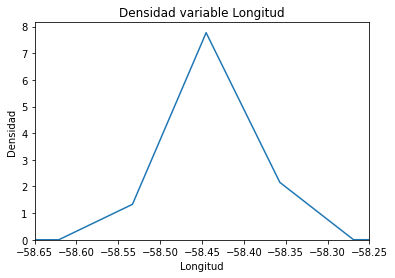

In [11]:
grf = sns.kdeplot(data=df_propiedades['longitud']).set(title = "Densidad variable Longitud",
                                                       xlabel="Longitud",
                                                       ylabel="Densidad",
                                                       xlim=(-58.65, -58.25))

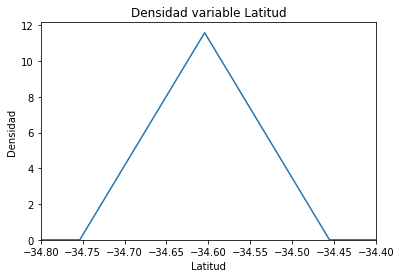

In [12]:
grf = sns.kdeplot(data=df_propiedades['latitud']).set(title = "Densidad variable Latitud",
                                                      xlabel="Latitud",
                                                      ylabel="Densidad",
                                                      xlim=(-34.8, -34.4))

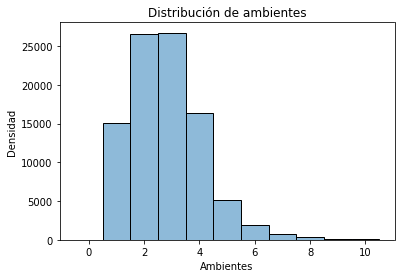

In [13]:
grf = sns.histplot(data=df_propiedades['ambientes'], alpha = 0.5, discrete=True, binrange=(0, 10)).set(title="Distribución de ambientes",xlabel="Ambientes",ylabel="Densidad")

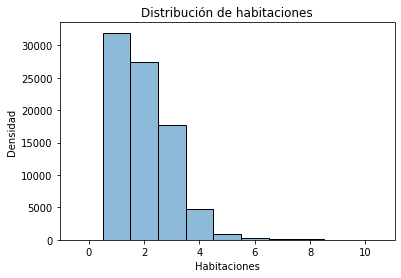

In [14]:
grf = sns.histplot(data=df_propiedades['habitaciones'], alpha = 0.5, discrete=True, binrange=(0, 10)).set(title="Distribución de habitaciones",xlabel="Habitaciones",ylabel="Densidad")

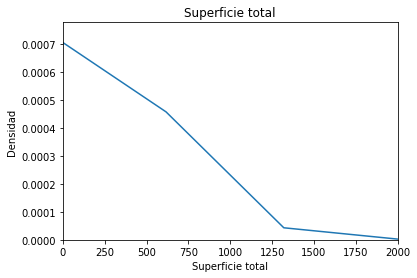

In [15]:
grf = sns.kdeplot(data=df_propiedades['superficie_total'], bw_adjust=5).set(title="Superficie total",xlabel="Superficie total",ylabel="Densidad", xlim=(0, 2000))

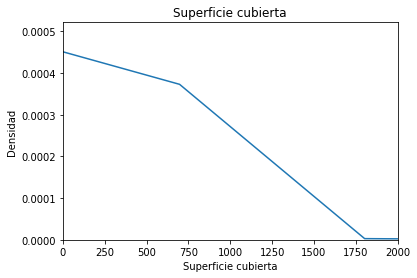

In [16]:
grf = sns.kdeplot(data=df_propiedades['superficie_cubierta'], bw_adjust=5).set(title="Superficie cubierta",xlabel="Superficie cubierta",ylabel="Densidad", xlim=(0, 2000))

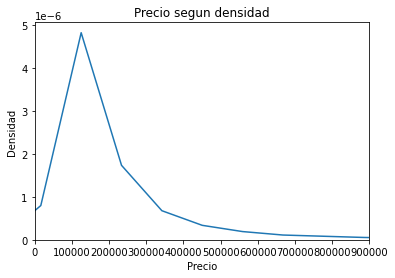

In [17]:
grf = sns.kdeplot(data=df_propiedades['precio']).set(title="Precio segun densidad",
                                                    xlabel="Precio",
                                                    ylabel="Densidad",
                                                    xlim=(0, 900000))

## Variables cualitativas

### Barrio

In [18]:
df_barrio = df_propiedades['barrio'].value_counts()

In [19]:
barrios_valores = df_barrio.index.tolist()
print(f'Lista de barrios en el dataset: {barrios_valores}')

Lista de barrios en el dataset: ['Palermo', 'Belgrano', 'Caballito', 'Recoleta', 'Villa Urquiza', 'Almagro', 'Nuñez', 'Villa Crespo', 'Flores', 'Barrio Norte', 'Balvanera', 'Colegiales', 'Villa Devoto', 'Villa del Parque', 'Saavedra', 'Puerto Madero', 'San Telmo', 'San Cristobal', 'San Nicolás', 'Retiro', 'Barracas', 'Boedo', 'Floresta', 'Monserrat', 'Parque Chacabuco', 'Villa Pueyrredón', 'Coghlan', 'Villa Luro', 'Mataderos', 'Chacarita', 'Liniers', 'Villa Ortuzar', 'Parque Patricios', 'Villa Lugano', 'Paternal', 'Congreso', 'Monte Castro', 'Constitución', 'Villa Santa Rita', 'Villa General Mitre', 'Once', 'Parque Avellaneda', 'Parque Chas', 'Boca', 'Versalles', 'Velez Sarsfield', 'Agronomía', 'Abasto', 'Pompeya', 'Villa Real', 'Tribunales', 'Parque Centenario', 'Centro / Microcentro', 'Villa Soldati', 'Villa Riachuelo', 'Las Cañitas', 'Catalinas']


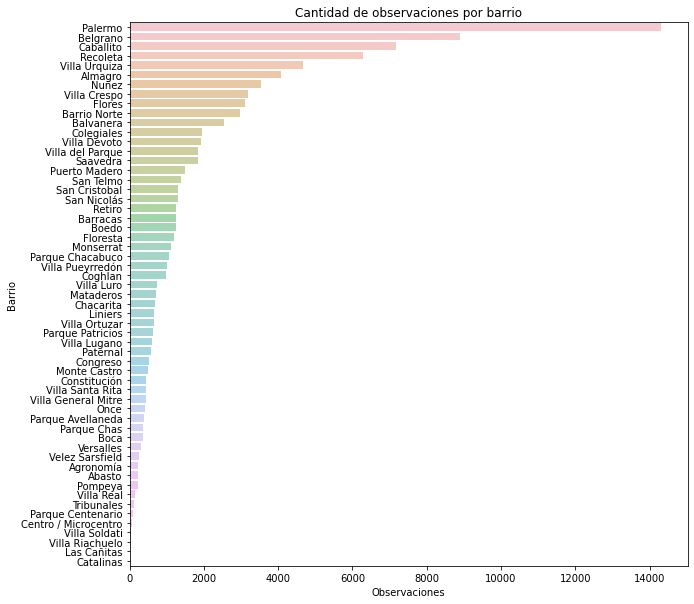

In [20]:
eje_y = df_barrio.index.tolist()
eje_x = df_barrio.tolist()

plt.figure(figsize = (10,10))
sns_bar_plot=sns.barplot(x=eje_x, y=eje_y ,alpha=0.5, orient="h").set(title="Cantidad de observaciones por barrio",
                                                                      xlabel='Observaciones',
                                                                      ylabel='Barrio')

### Tipo de propiedad

In [21]:
df_tipos = df_propiedades['tipo'].value_counts()

In [22]:
tipo_valores = df_tipos.index.tolist()
print(f'Tipos de propiedades: {tipo_valores}')

Tipos de propiedades: ['Departamento', 'PH', 'Casa']


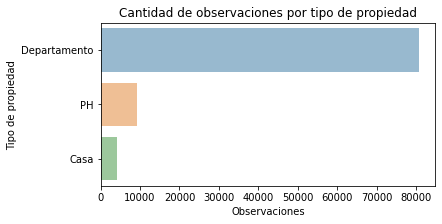

In [23]:
eje_y = df_tipos.index.tolist()
eje_x = df_tipos.tolist()

plt.figure(figsize = (6,3))
sns_bar_plot=sns.barplot(x=eje_x, y=eje_y ,alpha=0.5, orient="h").set(title="Cantidad de observaciones por tipo de propiedad",
                                                                      xlabel='Observaciones',
                                                                      ylabel='Tipo de propiedad')


# Correlaciones entre variables


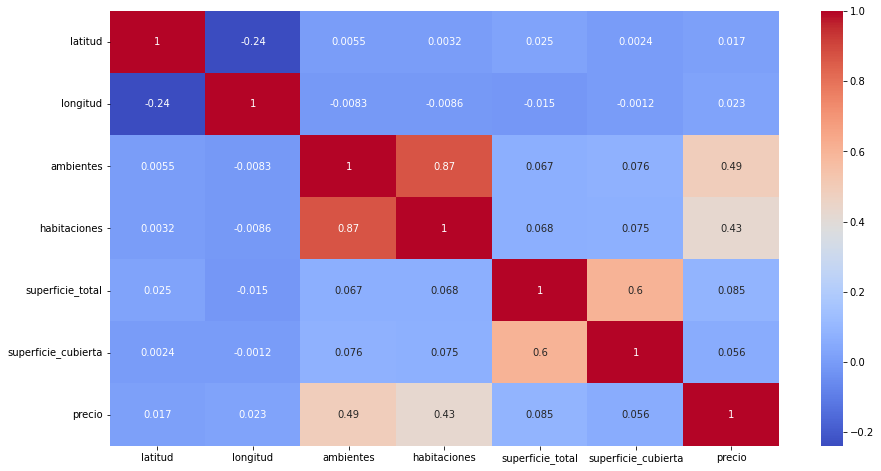

In [24]:
variables_cualitativas = ["fecha_inicio", "fecha_fin", "barrio", "sub-barrio", "place_l5", "place_l6", "tipo"]
df_propiedades_sin_cualitativas = df_propiedades.drop(columns=variables_cualitativas)
matriz_corr=df_propiedades_sin_cualitativas.corr()

plt.figure(figsize = (15,8))
sns.heatmap(matriz_corr, annot = True, cmap='coolwarm')

# Datos Faltantes

In [25]:
porcentajes_na = round(df_propiedades.isna().sum() * 100 / len(df_propiedades), 2)
porcentajes_na

fecha_inicio             0.00
fecha_fin                0.00
latitud                  3.96
longitud                 3.96
barrio                   0.44
sub-barrio              96.13
place_l5               100.00
place_l6               100.00
tipo                     0.00
ambientes                1.11
habitaciones            11.66
superficie_total         5.14
superficie_cubierta      3.56
precio                   0.00
dtype: float64

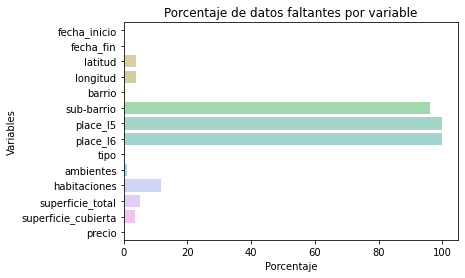

In [26]:
eje_y = porcentajes_na.index.tolist()
eje_x = porcentajes_na.tolist()

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y ,alpha=0.5, orient="h").set(title="Porcentaje de datos faltantes por variable",xlabel='Porcentaje',ylabel='Variables')

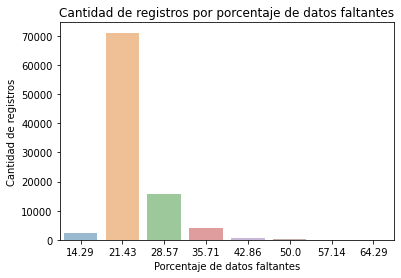

In [27]:
datos_faltantes_por_fila = (round(df_propiedades.isna().sum(axis=1) * 100 / len(df_propiedades.columns), 2)).value_counts()

eje_x = datos_faltantes_por_fila.index.tolist()
eje_y = datos_faltantes_por_fila.tolist()

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y ,alpha=0.5).set(title="Cantidad de registros por porcentaje de datos faltantes",xlabel='Porcentaje de datos faltantes',ylabel='Cantidad de registros')

# División en train y test

Para los modelos, tendremos como target a la variable precio.

In [28]:
from sklearn.model_selection import train_test_split

df_propiedades_x = df_propiedades.drop(columns=['precio'])
df_propiedades_y = df_propiedades['precio'].copy()

df_propiedades_train, df_propiedades_test, df_precio_train, df_precio_test = train_test_split(df_propiedades_x,
                                                                                              df_propiedades_y, 
                                                                                              test_size=0.2,
                                                                                              random_state=12)

# Imputación

In [29]:
df_propiedades_imputacion = df_propiedades_train.copy()

 ## Ambientes y habitaciones

Viendo que la cantidad de registros sin valor para la variable 'habitaciones' es no despreciable, y habiendo observado que la correlatividad entre ambientes y habitaciones es alta (0.87), podemos imputar los datos faltantes de habitaciones basandonos en los de ambientes.

In [30]:
cantidad_valores_na_habitaciones = df_propiedades_imputacion.habitaciones.isna().sum()
porcentaje_habitaciones_faltante = cantidad_valores_na_habitaciones * 100 / len(df_propiedades_imputacion)
print(f'Porcentaje de datos faltantes para habitaciones: {round(porcentaje_habitaciones_faltante, 2)}')
print(f'Cantidad de valores faltantes para habitaciones: {cantidad_valores_na_habitaciones}')

Porcentaje de datos faltantes para habitaciones: 11.69
Cantidad de valores faltantes para habitaciones: 8813


Realizamos una imputación del tipo Hot Deck. Completamos los datos faltantes utilizando la moda dada entre propiedades de igual cantidad de ambientes. 

In [31]:
# Obtengo los valores que toma la variable 'ambientes', sin tener en cuenta los cuales tienen el valor 'habitaciones' como valor faltante.
cantidad_de_ambientes = df_propiedades_imputacion.loc[df_propiedades_imputacion['habitaciones'].notna(), 'ambientes'].value_counts().index
# Me guardo un diccionario de modas para imputar el dataset de test
modas = {}
# Itero y para cada valor obtengo la moda de habitaciones (el valor de habitaciones más frecuente) de todas las filas con i cantidad de ambientes
for i in cantidad_de_ambientes:
  moda = df_propiedades_imputacion[(df_propiedades_imputacion['ambientes'] == i)]['habitaciones'].mode()[0]
  modas[i] = moda
  # Luego lleno los valores faltantes para las filas que tengan la misma cantidad de ambientes
  df_propiedades_imputacion.loc[(df_propiedades_imputacion['ambientes'] == i) & (df_propiedades_imputacion['habitaciones'].isna()), 'habitaciones'] = moda

cantidad_valores_na_habitaciones = df_propiedades_imputacion.habitaciones.isna().sum()
porcentaje_habitaciones_faltante = cantidad_valores_na_habitaciones * 100 / len(df_propiedades_imputacion)
print(f'Porcentaje de datos faltantes para habitaciones: {round(porcentaje_habitaciones_faltante, 2)}')
print(f'Cantidad de valores faltantes para habitaciones: {cantidad_valores_na_habitaciones}')

Porcentaje de datos faltantes para habitaciones: 0.47
Cantidad de valores faltantes para habitaciones: 356


Vemos que todavía no hay cero valores faltantes para la feature habitaciones, pero esto es porque en estos registros, la cantidad de ambientes también es un valor faltante, por lo que no se puede realizar el hot deck.

In [32]:
cant_reg_con_ambientes_habitaciones_na = len(df_propiedades_imputacion[df_propiedades_imputacion['habitaciones'].isna() & df_propiedades_imputacion['ambientes'].isna()])
print(f'Cantidad de registros con cant. de ambientes y habitaciones faltantes: {cant_reg_con_ambientes_habitaciones_na}')

Cantidad de registros con cant. de ambientes y habitaciones faltantes: 355


Estos registros con ambos valores faltantes pueden ser eliminados, ya que no poseen suficiente información para que podamos extraer conclusiones de ellos, y no hay otras columnas con suficiente correlatividad para poder imputar estos datos de una forma precisa.

In [33]:
df_propiedades_imputacion = df_propiedades_imputacion[(df_propiedades_imputacion['habitaciones'].notna()) & (df_propiedades_imputacion['ambientes'].notna())]
print(f'Cantidad de datos faltantes en ambientes: {df_propiedades_imputacion.ambientes.isna().sum()}')
print(f'Cantidad de datos faltantes en habitaciones: {df_propiedades_imputacion.habitaciones.isna().sum()}')

Cantidad de datos faltantes en ambientes: 0
Cantidad de datos faltantes en habitaciones: 0


Podemos ver en los siguientes gráficos que la distribución no cambia significativamente al realizar este tipo de imputación.

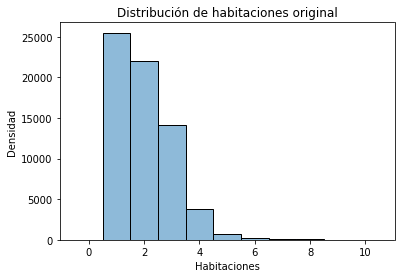

In [34]:
grf_discr_ambientes = sns.histplot(data=df_propiedades_train['habitaciones'], alpha = 0.5, discrete=True, binrange=(0, 10)).set(title="Distribución de habitaciones original",xlabel="Habitaciones",ylabel="Densidad")

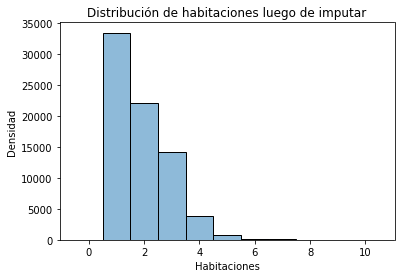

In [35]:
grf_discr_ambientes_imp = sns.histplot(data=df_propiedades_imputacion['habitaciones'], alpha = 0.5, discrete=True, binrange=(0, 10)).set(title="Distribución de habitaciones luego de imputar",xlabel="Habitaciones",ylabel="Densidad")

 ## Latitud, longitud y barrio

 En el caso en que haya información sobre la latitud y longitud, pero no del barrio, podremos realizar una imputación de tipo 'cold deck' para rellenar basándonos en otro dataset con la información correspondiente. Pero, en caso de no tener otro dataset podremos imputar los datos utilizando el algoritmo 'K-vecinos más cercanos' (a implementar). Antes de ello tendremos que deshacernos de los registros que no contengan datos de barrios, y tampoco de latitud y longitud.

In [36]:
df_valores_sin_lat_lon_barrio = (df_propiedades_imputacion[['latitud', 'longitud', 'barrio']].isna().sum(axis=1) == 3)
df_propiedades_imputacion.drop(df_propiedades_imputacion[df_valores_sin_lat_lon_barrio].index, inplace=True)
cantidad_na_lon_lat_barrio = (df_propiedades_imputacion[['latitud', 'longitud', 'barrio']].isna().sum(axis=1) == 3).sum()
print(f'Cantidad de filas sin ninguno de los tres valores: {cantidad_na_lon_lat_barrio}')

Cantidad de filas sin ninguno de los tres valores: 0


In [37]:
cant_filas_con_lon_lat_sin_barrio = (df_propiedades_imputacion[['latitud', 'longitud']].notna().sum(axis=1) == 2 & df_propiedades_imputacion['barrio'].isna()).sum()
print(f'Cantidad de filas con latitud y longitud pero sin barrio: {cant_filas_con_lon_lat_sin_barrio}')

Cantidad de filas con latitud y longitud pero sin barrio: 2757


Ahora podemos usar K-vecinos más cercanos para imputar aquellas filas donde se tenga la informacion de latitud y longitud pero no la de barrio:

In [38]:
from sklearn.impute import KNNImputer

columnas = ['latitud', 'longitud', 'barrio']
df_propiedades_imputacion_knn = df_propiedades_imputacion[columnas].copy()
barrio_dummies = pd.get_dummies(df_propiedades_imputacion['barrio'], drop_first=False)
df_propiedades_imputacion_knn.drop('barrio', axis='columns', inplace=True)
df_propiedades_imputacion_knn = pd.concat([df_propiedades_imputacion_knn, barrio_dummies], axis='columns')
columnas_con_dummies = df_propiedades_imputacion_knn.columns
barrio_imp = KNNImputer(n_neighbors=5, weights='distance')

df_propiedades_imputacion_knn = barrio_imp.fit_transform(df_propiedades_imputacion_knn)
df_propiedades_imputacion_knn = pd.DataFrame(df_propiedades_imputacion_knn,columns = columnas_con_dummies)


In [39]:
df_barrios_imputados = df_propiedades_imputacion_knn.drop(columns=['latitud', 'longitud']).idxmax(axis=1)
df_propiedades_imputacion['barrio'] = df_barrios_imputados.to_numpy()

## Superficie total y cubierta

Las features 'superficie_total' y 'superficie_cubierta' tienen una correlatividad de 0.6, lo suficientemente alta para poder justificar una imputación entre ellas utilizando el otro dato faltante. Podemos ver la cantidad de columnas en donde al menos uno de los datos falta:

In [40]:
cant_filas_con_total_sin_cub = ((df_propiedades_imputacion['superficie_total'].notna()) & (df_propiedades_imputacion['superficie_cubierta'].isna())).sum()
cant_filas_sin_total_con_cub = ((df_propiedades_imputacion['superficie_total'].isna()) & (df_propiedades_imputacion['superficie_cubierta'].notna())).sum()
cant_filas_sin_total_sin_cub = ((df_propiedades_imputacion['superficie_total'].isna()) & (df_propiedades_imputacion['superficie_cubierta'].isna())).sum()
print(f'Cantidad de registros con superficie total y sin superficie cubierta: {cant_filas_con_total_sin_cub}')
print(f'Cantidad de registros sin superficie total y con superficie cubierta: {cant_filas_sin_total_con_cub}')
print(f'Cantidad de registros sin superficie total y sin superficie cubierta: {cant_filas_sin_total_sin_cub}')

Cantidad de registros con superficie total y sin superficie cubierta: 2638
Cantidad de registros sin superficie total y con superficie cubierta: 3630
Cantidad de registros sin superficie total y sin superficie cubierta: 0


Para completar estos datos usaremos una imputación de tipo MICE. Es decir, realizaremos regresión lineal sobre los datos faltantes para poder rellenarlos basándonos en el dato que sí tenemos. De esta manera podremos completar todos los datos de superficies.

In [41]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas=['superficie_total','superficie_cubierta']
df_eliminar_nans=df_propiedades_imputacion[columnas].copy()

lr = LinearRegression()
superficie_imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0)
df_propiedades_imputacion.loc[:, columnas] = superficie_imp.fit_transform(df_eliminar_nans)

Al realizar esta imputación podemos ver que ya no hay datos faltantes para las superficies.

In [42]:
cant_filas_con_total_sin_cub = ((df_propiedades_imputacion['superficie_total'].notna()) & (df_propiedades_imputacion['superficie_cubierta'].isna())).sum()
cant_filas_sin_total_con_cub = ((df_propiedades_imputacion['superficie_total'].isna()) & (df_propiedades_imputacion['superficie_cubierta'].notna())).sum()
cant_filas_sin_total_sin_cub = ((df_propiedades_imputacion['superficie_total'].isna()) & (df_propiedades_imputacion['superficie_cubierta'].isna())).sum()
print(f'Cantidad de registros con superficie total y sin superficie cubierta: {cant_filas_con_total_sin_cub}')
print(f'Cantidad de registros sin superficie total y con superficie cubierta: {cant_filas_sin_total_con_cub}')
print(f'Cantidad de registros sin superficie total y sin superficie cubierta: {cant_filas_sin_total_sin_cub}')

Cantidad de registros con superficie total y sin superficie cubierta: 0
Cantidad de registros sin superficie total y con superficie cubierta: 0
Cantidad de registros sin superficie total y sin superficie cubierta: 0


También se puede comparar la distribución de ambas variables antes y después de imputar.

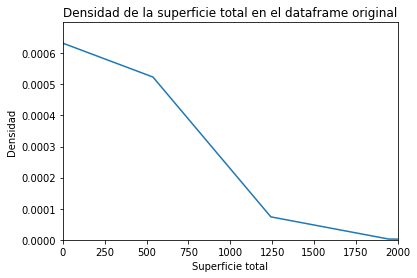

In [43]:
grf_superficie_total = sns.kdeplot(data=df_propiedades_train['superficie_total'], bw_adjust=5).set(title="Densidad de la superficie total en el dataframe original",xlabel="Superficie total",ylabel="Densidad", xlim=(0, 2000))

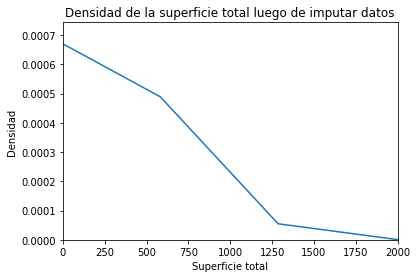

In [44]:
grf_superficie_total = sns.kdeplot(data=df_propiedades_imputacion['superficie_total'], bw_adjust=5).set(title="Densidad de la superficie total luego de imputar datos",xlabel="Superficie total",ylabel="Densidad", xlim=(0, 2000))

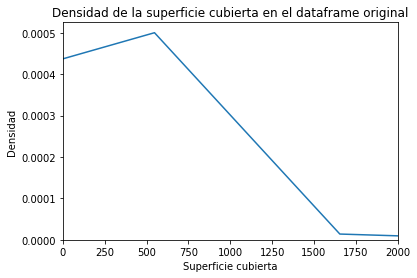

In [45]:
grf_superficie_cubierta = sns.kdeplot(data=df_propiedades_train['superficie_cubierta'], bw_adjust=5).set(title="Densidad de la superficie cubierta en el dataframe original",xlabel="Superficie cubierta",ylabel="Densidad", xlim=(0, 2000))

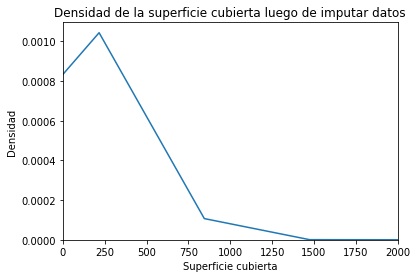

In [46]:
grf_superficie_cubierta = sns.kdeplot(data=df_propiedades_imputacion['superficie_cubierta'], bw_adjust=5).set(title="Densidad de la superficie cubierta luego de imputar datos",xlabel="Superficie cubierta",ylabel="Densidad", xlim=(0, 2000))

## sub-barrio, place_l5, y place_l6



Estas features están en su mayoría vacías. Sus datos no son lo suficientemente representantes de la población para poder considerarlos, por lo tanto decidimos eliminarlas.

In [47]:
df_propiedades_imputacion.drop(columns=['sub-barrio', 'place_l5', 'place_l6'], inplace=True)

Luego de realizar todas las imputaciones, vemos que el gráfico de imputaciones mejoró drásticamente, teniendo una cota superior de datos faltantes de menos del 4% por columna, siendo estos datos mayormente de latitud y longitud.

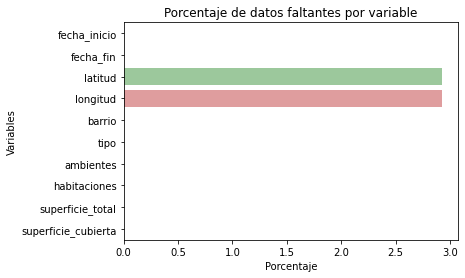

In [48]:
porcentajes_na = round(df_propiedades_imputacion.isna().sum() * 100 / len(df_propiedades), 2)
eje_y = porcentajes_na.index.tolist()
eje_x = porcentajes_na.tolist()

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y ,alpha=0.5, orient="h").set(title="Porcentaje de datos faltantes por variable",xlabel='Porcentaje',ylabel='Variables')

In [49]:
df_propiedades_train = df_propiedades_imputacion.copy()
df_precio_train = df_precio_train.loc[df_propiedades_imputacion.index.to_numpy().tolist()]

## Imputación del dataset de test

Imputo los datos del dataset de test usando los datos de train:

In [50]:
df_propiedades_imputacion_test = df_propiedades_test.copy()

In [51]:
# Imputación de habitaciones usando la moda
for i in cantidad_de_ambientes:
  df_propiedades_imputacion_test.loc[(df_propiedades_imputacion_test['ambientes'] == i) & (df_propiedades_imputacion_test['habitaciones'].isna()), 'habitaciones'] = modas[i]

In [52]:
# Elimino las propiedades sin ambientes ni habitaciones
df_propiedades_imputacion_test = df_propiedades_imputacion_test[(df_propiedades_imputacion_test['habitaciones'].notna()) & (df_propiedades_imputacion_test['ambientes'].notna())]

In [53]:
# Elimino las propiedades sin latitud, longitud ni barrio
propiedades_sin_lat_lon_barrio = df_propiedades_imputacion_test[df_propiedades_imputacion_test[['latitud', 'longitud', 'barrio']].isna().sum(axis=1) == 3]
df_propiedades_imputacion_test.drop(propiedades_sin_lat_lon_barrio.index, inplace=True)

In [54]:
# Imputo los valores de barrio usando latitud y longitud con KNN
columnas = ['latitud', 'longitud', 'barrio']
df_propiedades_imputacion_test_knn = df_propiedades_imputacion_test[columnas].copy()
barrio_dummies = pd.get_dummies(df_propiedades_imputacion_test['barrio'], drop_first=False)
df_propiedades_imputacion_test_knn.drop('barrio', axis='columns', inplace=True)
df_propiedades_imputacion_test_knn = pd.concat([df_propiedades_imputacion_test_knn, barrio_dummies], axis='columns')
columnas_con_dummies = df_propiedades_imputacion_test_knn.columns

In [55]:
df_propiedades_imputacion_test_knn = barrio_imp.transform(df_propiedades_imputacion_test_knn)
df_propiedades_imputacion_test_knn = pd.DataFrame(df_propiedades_imputacion_test_knn,columns = columnas_con_dummies)

In [56]:
df_barrios_imputados_test = df_propiedades_imputacion_test_knn.drop(columns=['latitud', 'longitud']).idxmax(axis=1)
df_propiedades_imputacion_test['barrio'] = df_barrios_imputados_test.to_numpy()

In [57]:
# Utilizo regresión lineal para rellenar las columnas de superficie cubierta y total
columnas=['superficie_total','superficie_cubierta']
df_propiedades_imputacion_test.loc[:, columnas] = superficie_imp.transform(df_propiedades_imputacion_test[columnas])

In [58]:
# Elimino las columnas sub-barrio, place_l5 y place_l6
df_propiedades_imputacion_test.drop(columns=['sub-barrio', 'place_l5', 'place_l6'], inplace=True)

In [59]:
df_propiedades_test = df_propiedades_imputacion_test.copy()
df_precio_test = df_precio_test.loc[df_propiedades_imputacion_test.index.to_numpy().tolist()]

# Valores atípicos

In [60]:
df_propiedades_atipicos_train = df_propiedades_train.copy()
df_precio_atipicos_train = df_precio_train.copy()

## Latitud y longitud

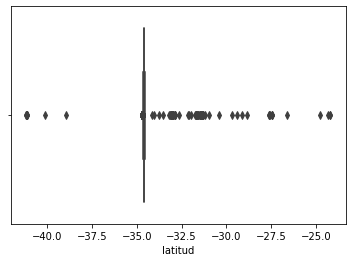

In [61]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.latitud)

Dado que los limites de latitud de CABA se encuentran entre -34.50 y -34.70 podemos descartar del data set cualquier propiedad que se encuentre por fuera.

In [62]:
propiedades_a_eliminar = df_propiedades_atipicos_train[(df_propiedades_atipicos_train['latitud'] > -34.50) | (df_propiedades_atipicos_train['latitud'] < -34.70)]
df_propiedades_atipicos_train.drop(propiedades_a_eliminar.index, axis='rows', inplace=True)
df_precio_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)

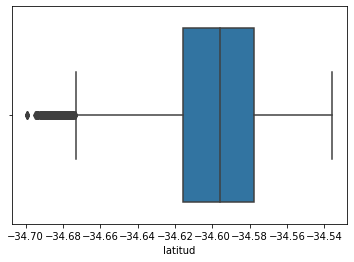

In [63]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.latitud)

Podemos realizar un análisis similar para la longitud, la cuál varía entre -58.53 y -58.35

In [64]:
len(df_propiedades_atipicos_train[(df_propiedades_atipicos_train['longitud'] < -58.53) | (df_propiedades_atipicos_train['longitud'] > -58.35)])

15

Por lo que podemos observar, 15 registros están por fuera de estos límites. Podemos borrar estas propiedades, ya que probablemente sean datos mal cargados.

In [65]:
propiedades_a_eliminar = df_propiedades_atipicos_train[(df_propiedades_atipicos_train['longitud'] < -58.53) | (df_propiedades_atipicos_train['longitud'] > -58.35)]
df_propiedades_atipicos_train.drop(propiedades_a_eliminar.index, axis='rows', inplace=True)
df_precio_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)

Y podemos verificar que fueron efectivamente eliminados:

In [66]:
len(df_propiedades_atipicos_train[(df_propiedades_atipicos_train['longitud'] < -58.53) | (df_propiedades_atipicos_train['longitud'] > -58.35)])

0

Mostrar boxplots puede ayudar a ver la diferencia entre el dataset con estos datos erroneamente cargados y y el mismo dataset luego de eliminarlos.

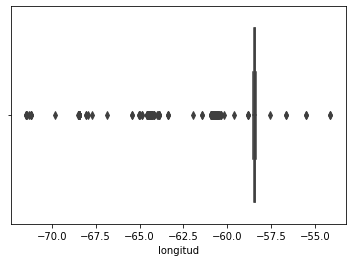

In [67]:
grf = sns.boxplot(x=df_propiedades.longitud)

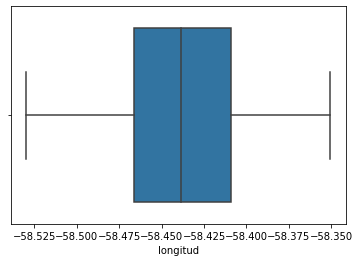

In [68]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.longitud)

## Fechas

Se puede hacer otro análisis univariado para las fechas. Debido a que este dataset fue hecho para el año 2021, las fechas de inicio que tengan otro año deben ser erróneos.

In [69]:
df_propiedades_atipicos_train_fechas = df_propiedades_atipicos_train.copy()
df_propiedades_atipicos_train_fechas['año_inicio'] = df_propiedades_atipicos_train_fechas['fecha_inicio'].apply(lambda x: x.split('-')[0])
df_propiedades_atipicos_train_fechas['año_inicio'] = pd.to_numeric(df_propiedades_atipicos_train_fechas['año_inicio'])
df_propiedades_atipicos_train_fechas['año_fin'] = df_propiedades_atipicos_train_fechas['fecha_fin'].apply(lambda x: x.split('-')[0])
df_propiedades_atipicos_train_fechas['año_fin'] = pd.to_numeric(df_propiedades_atipicos_train_fechas['año_fin'])

In [70]:
df_propiedades_atipicos_train_fechas['año_inicio'].value_counts()

2021    74317
Name: año_inicio, dtype: int64

In [71]:
df_propiedades_atipicos_train_fechas['año_fin'].value_counts()

2021    48521
2022    21859
9999     3937
Name: año_fin, dtype: int64

En este caso, 'fecha_inicio' parece no tener outliers a simple vista. Sin embargo, 'fecha_fin' si tiene, es el valor 9999. Si nos fijamos los valores de fecha_fin para ese valor de año, podemos ver que es un valor absurdo, y probablemente signifique que la publicación aún no se ha cerrado.

In [72]:
df_propiedades_atipicos_train_fechas[df_propiedades_atipicos_train_fechas['año_fin'] == 9999]['fecha_fin'].value_counts()

9999-12-31    3937
Name: fecha_fin, dtype: int64

In [73]:
porcentaje_no_cerrados = len(df_propiedades_atipicos_train_fechas[df_propiedades_atipicos_train_fechas['año_fin'] == 9999]) * 100 / len(df_propiedades_atipicos_train_fechas)
print(f'Porcentaje de fechas erroneas: {round(porcentaje_no_cerrados, 2)}%')

Porcentaje de fechas erroneas: 5.3%


Ya que no consideramos a las fechas como un feature importante, los valores pueden quedar como están.

## Superficie total y cubierta

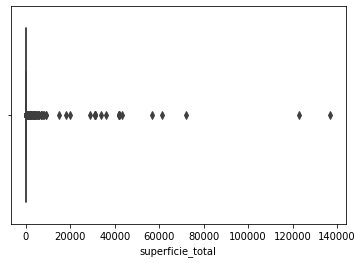

In [74]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.superficie_total)

Al igual que las otras variables analizadas, a simple vista se pueden ver varios outliers. Debido a que Capital Federal es una zona urbana, y teniendo en cuenta que sólo se consideran casas, PHs y departamentos, cualquier valor por encima de 10000 metros cuadrados (100m x 100m, una cuadra entera) debería ser observado más cercanamente, ya que es posible que sea un valor erróneo o mal cargado.

In [75]:
df_propiedades_atipicos_train.loc[df_propiedades_atipicos_train['superficie_total'] > 10000, ['superficie_total', 'superficie_cubierta', 'tipo']]

,superficie_total,superficie_cubierta,tipo
264624,14744.0,13717.0,Departamento
459847,18096.0,8568.0,Departamento
353009,31000.0,26.0,Departamento
117835,43086.0,40038.0,Departamento
370922,42110.0,307.0,Departamento
72316,61130.0,53030.0,Departamento
219021,72060.0,90.0,Departamento
324541,20041.0,139.0,PH
72521,33800.0,31670.0,Departamento
370917,42110.0,222.0,Departamento


Podemos ver que en varios casos es claro que hubo un error de tipeo al ingresar el registro. Por ejemplo, podemos investigar el registro 353009:

In [76]:
df_propiedades_atipicos_train.loc[353009, :]

fecha_inicio             2021-06-25
fecha_fin                2021-08-10
latitud                  -34.579163
longitud                 -58.455725
barrio                   Colegiales
tipo                   Departamento
ambientes                       1.0
habitaciones                    1.0
superficie_total            31000.0
superficie_cubierta            26.0
Name: 353009, dtype: object

En este caso es claro que, al ser un departamento, no puede tener 31000m2. Lo que asumimos es un error de tipeo, cuando el valor correcto debería ser 31 metros cuadrados.
Arreglar estos campos requiere analizar los valores en los que es posible que se haya tipeado mal. En general, si superficie cubierta no supera los 500 metros cuadrados, podemos asumir que hubo un error de tipeo:

In [77]:
df_propiedades_atipicos_train.loc[(df_propiedades_atipicos_train['superficie_total'] > 10000) & (df_propiedades_atipicos_train['superficie_cubierta'] < 500), ['superficie_total', 'superficie_cubierta', 'tipo']]

,superficie_total,superficie_cubierta,tipo
353009,31000.0,26.0,Departamento
370922,42110.0,307.0,Departamento
219021,72060.0,90.0,Departamento
324541,20041.0,139.0,PH
370917,42110.0,222.0,Departamento
362741,31000.0,26.0,Departamento
370932,42110.0,307.0,Departamento
300394,31000.0,26.0,Departamento
84073,36000.0,30.0,Departamento
126869,31000.0,26.0,Departamento


Quitando el registro 129214, el resto puede repararse diviendo el resultado por 100:

In [78]:
df_propiedades_atipicos_train.loc[df_propiedades_atipicos_train['superficie_total'] == 137000.0, 'superficie_total'] = df_propiedades_atipicos_train.loc[129214, 'superficie_total'] / 10

df_propiedades_atipicos_train.loc[df_propiedades_atipicos_train['superficie_total'] > 10000, 'superficie_total'] /= 100
df_propiedades_atipicos_train.loc[df_propiedades_atipicos_train['superficie_cubierta'] > 10000, 'superficie_cubierta'] /= 100

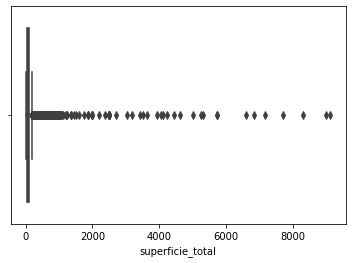

In [79]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.superficie_total)

Vemos que sigue habiendo valores atipicos. Estos valores pueden ser descartados immediatamente si superan los 10000 metros cuadrados.

In [80]:
propiedades_a_eliminar = df_propiedades_atipicos_train[df_propiedades_atipicos_train['superficie_total'] > 10000]
df_propiedades_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)
df_precio_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)

In [81]:
cant_prop_mas_de_diez_mil_sup = len(df_propiedades_atipicos_train[df_propiedades_atipicos_train['superficie_total'] > 10000])
print(f'Cantidad de propiedades en el dataset con mas de 10000 metros cuadrados: {cant_prop_mas_de_diez_mil_sup}')

Cantidad de propiedades en el dataset con mas de 10000 metros cuadrados: 0


Siguiendo el procedimiento anterior, podemos analizar los valores mayores a 2000 metros cuadrados.

In [82]:
df_propiedades_atipicos_train.loc[df_propiedades_atipicos_train['superficie_total'] > 2000, ['superficie_total', 'superficie_cubierta', 'tipo']]

,superficie_total,superficie_cubierta,tipo
59214,2500.0,66.000000,Departamento
405272,8306.0,7755.000000,PH
459849,7720.0,5970.000000,Departamento
314539,2500.0,51.000000,Departamento
104177,3623.0,3615.000000,Departamento
35538,3500.0,60.000000,Departamento
149946,5736.0,57.000000,PH
293109,5239.0,2002.569398,Departamento
34113,2500.0,51.000000,Departamento
406490,2500.0,66.000000,Departamento


Ya que los departamentos usualmente tienen la mayor parte de su superficie bajo techo, podemos descartar todos los departamentos que tengan menos del 50% de su superficie cubierta.

In [83]:
df_propiedades_atipicos_train.loc[(df_propiedades_atipicos_train['superficie_total'] > 2000) &
                            (df_propiedades_atipicos_train['tipo'] == 'Departamento') &
                            (df_propiedades_atipicos_train['superficie_cubierta'] * 100 / df_propiedades_atipicos_train['superficie_total'] < 50),
                            ['superficie_total', 'superficie_cubierta', 'tipo']]

,superficie_total,superficie_cubierta,tipo
59214,2500.0,66.000000,Departamento
314539,2500.0,51.000000,Departamento
35538,3500.0,60.000000,Departamento
293109,5239.0,2002.569398,Departamento
34113,2500.0,51.000000,Departamento
406490,2500.0,66.000000,Departamento
442647,6836.0,64.000000,Departamento
195264,2500.0,51.000000,Departamento
400155,4632.0,42.000000,Departamento
324150,4053.0,38.000000,Departamento


In [84]:
departamentos_a_eliminar = df_propiedades_atipicos_train[(df_propiedades_atipicos_train['superficie_total'] > 2000) &
                            (df_propiedades_atipicos_train['tipo'] == 'Departamento') &
                            (df_propiedades_atipicos_train['superficie_cubierta'] * 100 / df_propiedades_atipicos_train['superficie_total'] < 50)]
df_propiedades_atipicos_train.drop(departamentos_a_eliminar.index, inplace=True)
df_precio_atipicos_train.drop(departamentos_a_eliminar.index, inplace=True)

In [85]:
len(df_propiedades_atipicos_train[(df_propiedades_atipicos_train['superficie_total'] > 2000) &
                            (df_propiedades_atipicos_train['tipo'] == 'Departamento') &
                            (df_propiedades_atipicos_train['superficie_cubierta'] * 100 / df_propiedades_atipicos_train['superficie_total'] < 50)])

0

Además, podemos descartar cualquier propiedad que tenga un valor de superficie_total menor al de superficie_cubierta.

In [86]:
propiedades_a_eliminar = df_propiedades_atipicos_train[df_propiedades_atipicos_train['superficie_total'] < df_propiedades_atipicos_train['superficie_cubierta']]
df_propiedades_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)
df_precio_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)

## Ambientes y habitaciones

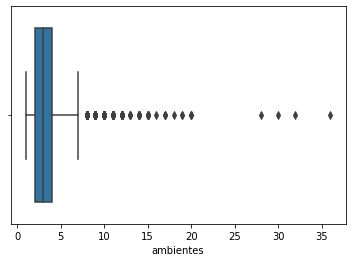

In [87]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.ambientes)

Analicemos los casos en los que la propiedad tenga más de 15 ambientes.

In [88]:
columnas = ['ambientes', 'habitaciones', 'superficie_cubierta', 'tipo', 'latitud', 'longitud']
df_propiedades_atipicos_train.loc[df_propiedades_atipicos_train['ambientes'] > 15, columnas]

,ambientes,habitaciones,superficie_cubierta,tipo,latitud,longitud
346602,19.0,18.0,318.000000,Departamento,-34.632537,-58.360577
52157,30.0,2.0,60.000000,PH,-34.649872,-58.483012
147918,36.0,18.0,547.866284,Departamento,NaN,NaN
225809,16.0,12.0,580.000000,Casa,-34.616239,-58.371198
32758,19.0,18.0,318.000000,PH,-34.632698,-58.360514
402448,17.0,16.0,458.000000,Casa,-34.611413,-58.389221
90004,32.0,32.0,435.000000,PH,-34.633236,-58.480313
211468,20.0,1.0,31.000000,Departamento,-34.618153,-58.362615
332857,18.0,17.0,334.000000,Departamento,-34.611905,-58.382384
90686,17.0,8.0,616.000000,Casa,-34.590064,-58.395623


Podemos eliminarlos.

In [89]:
propiedades_a_eliminar = df_propiedades_atipicos_train[df_propiedades_atipicos_train['ambientes'] > 15]
df_propiedades_atipicos_train.drop(propiedades_a_eliminar.index, axis='rows', inplace=True)
df_precio_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)

Además, ninguna propiedad puede tener más habitaciones que ambientes, por lo tanto se puede borrar esos registros por ser imprecisos:

In [90]:
propiedades_a_eliminar = df_propiedades_atipicos_train[df_propiedades_atipicos_train['habitaciones'] > df_propiedades_atipicos_train['ambientes']]
df_propiedades_atipicos_train.drop(propiedades_a_eliminar.index, axis='rows', inplace=True)
df_precio_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)

No se puede deducir nada que indique que los valores restantes son errores, ya que su cantidad de ambientes es razonable para la superficie cubierta.

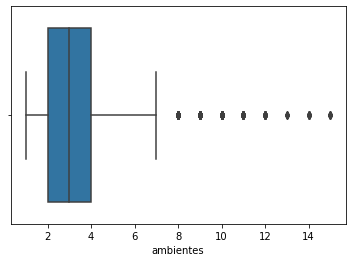

In [91]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.ambientes)

Ahora, podemos hacer lo mismo con la cantidad de habitaciones.

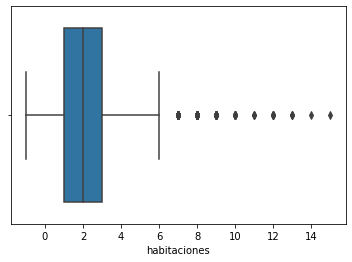

In [92]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.habitaciones)

In [93]:
propiedades_a_eliminar = df_propiedades_atipicos_train[df_propiedades_atipicos_train['habitaciones'] > 15]
df_propiedades_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)
df_precio_atipicos_train.drop(propiedades_a_eliminar.index, inplace=True)

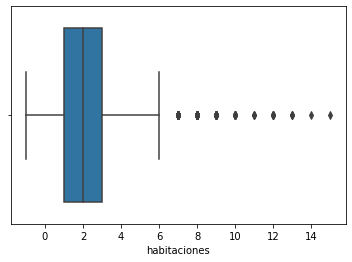

In [94]:
grf = sns.boxplot(x=df_propiedades_atipicos_train.habitaciones)

## Precio

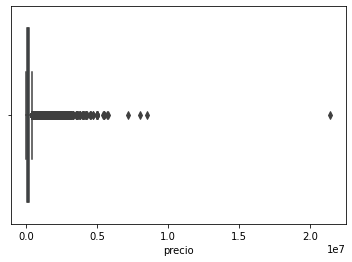

In [95]:
grf = sns.boxplot(x=df_precio_atipicos_train)

Podemos empezar una exploración inicial de estos valores empezando por los que sean mayores a 5 millones de dólares.

In [96]:
columnas = ['ambientes', 'superficie_total', 'superficie_cubierta', 'tipo', "latitud", "longitud"]
precio_mayores_a_cinco_millones = df_precio_atipicos_train[df_precio_atipicos_train > 1000000]
df_propiedades_atipicos_train.loc[precio_mayores_a_cinco_millones.index, columnas]

,ambientes,superficie_total,superficie_cubierta,tipo,latitud,longitud
372581,6.0,280.0,280.000000,Departamento,-34.591096,-58.377854
344936,7.0,425.0,425.000000,Departamento,-34.559873,-58.449254
381298,6.0,274.0,232.000000,Departamento,-34.584125,-58.416086
397227,5.0,400.0,265.000000,Departamento,-34.547825,-58.456306
185199,4.0,176.0,166.000000,Departamento,-34.562403,-58.443159
...,...,...,...,...,...,...
175228,6.0,768.0,353.000000,Casa,-34.576488,-58.465870
327199,3.0,216.0,216.000000,Departamento,-34.547911,-58.456533
72324,5.0,237.0,200.000000,Departamento,-34.578743,-58.402954
271227,8.0,568.0,256.252707,Casa,-34.584391,-58.428946


In [97]:
indice_propiedad_con_alto_precio = df_precio_atipicos_train[df_precio_atipicos_train == 21400000].index
df_propiedades_atipicos_train.loc[indice_propiedad_con_alto_precio, columnas]

,ambientes,superficie_total,superficie_cubierta,tipo,latitud,longitud
60073,3.0,68.0,64.0,Departamento,-34.616044,-58.458621


De esto no podemos decir nada, excepto por la propiedad de 21 millones de dólares. Al ser un departamento con poca superficie total, podemos descartarlo.

In [98]:
df_propiedades_atipicos_train.drop(indice_propiedad_con_alto_precio, axis='rows', inplace=True)
df_precio_atipicos_train.drop(indice_propiedad_con_alto_precio, inplace=True)

In [99]:
df_propiedades_train = df_propiedades_atipicos_train.copy()
df_propiedades_train.to_csv('df_propiedades_train.csv', index=False)

In [100]:
df_precio_train = df_precio_atipicos_train.copy()
df_precio_train.to_csv('df_precio_train.csv', index=False)

## Valores atípicos del dataset de test

In [101]:
df_propiedades_atipicos_test = df_propiedades_test.copy()
df_precio_atipicos_test = df_precio_test.copy()

### Latitud y longitud

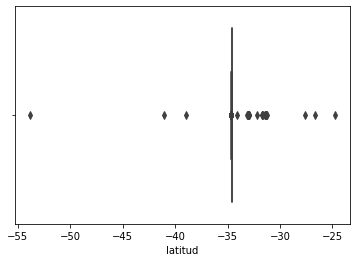

In [102]:
grf = sns.boxplot(x=df_propiedades_atipicos_test.latitud)

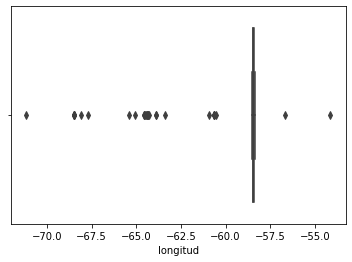

In [103]:
grf = sns.boxplot(x=df_propiedades_atipicos_test.longitud)

En latitud y longitud, el dataset de testeo tiene varios outliers que probablemente estén fuera del límite de la ciudad, por lo que los borramos usando los mismos valores que en el dataset de training.

In [104]:
propiedades_a_eliminar = df_propiedades_atipicos_test[(df_propiedades_atipicos_test['latitud'] > -34.50) | (df_propiedades_atipicos_test['latitud'] < -34.70)]
df_propiedades_atipicos_test.drop(propiedades_a_eliminar.index, axis='rows', inplace=True)
df_precio_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)

### Fechas

In [105]:
df_propiedades_atipicos_test_fechas = df_propiedades_atipicos_test.copy()
df_propiedades_atipicos_test_fechas['año_inicio'] = df_propiedades_atipicos_test_fechas['fecha_inicio'].apply(lambda x: x.split('-')[0])
df_propiedades_atipicos_test_fechas['año_inicio'] = pd.to_numeric(df_propiedades_atipicos_test_fechas['año_inicio'])
df_propiedades_atipicos_test_fechas['año_fin'] = df_propiedades_atipicos_test_fechas['fecha_fin'].apply(lambda x: x.split('-')[0])
df_propiedades_atipicos_test_fechas['año_fin'] = pd.to_numeric(df_propiedades_atipicos_test_fechas['año_fin'])

In [106]:
df_propiedades_atipicos_train_fechas['año_inicio'].value_counts()

2021    74317
Name: año_inicio, dtype: int64

In [107]:
df_propiedades_atipicos_train_fechas['año_fin'].value_counts()

2021    48521
2022    21859
9999     3937
Name: año_fin, dtype: int64

Al igual que en el dataset de training, hay fechas en el año 9999. Como asumimos que estas fechas representan la venta de una propiedad que todavía no se cerro, mantenemos sus valores.

### Superficie total y cubierta

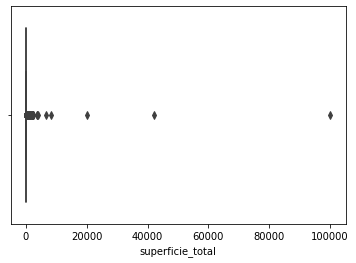

In [108]:
grf = sns.boxplot(x=df_propiedades_atipicos_test.superficie_total)

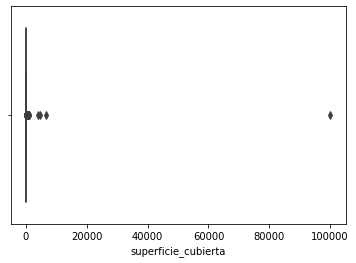

In [109]:
grf = sns.boxplot(x=df_propiedades_atipicos_test.superficie_cubierta)

In [110]:
df_propiedades_atipicos_test.loc[df_propiedades_atipicos_test['superficie_total'] > 10000, ['superficie_total', 'superficie_cubierta', 'tipo']]

,superficie_total,superficie_cubierta,tipo
372779,100068.0,100051.0,Departamento
237392,20041.0,139.0,PH
370919,42110.0,307.0,Departamento


Al igual que en el dataset anterior, podemos asumir que estos valores son resultado de un error en unidades, por lo que podemos proceder de la misma manera para arreglar los outliers.

In [111]:
df_propiedades_atipicos_test.loc[df_propiedades_atipicos_test['superficie_total'] > 10000, 'superficie_total'] /= 100
df_propiedades_atipicos_test.loc[df_propiedades_atipicos_test['superficie_cubierta'] > 10000, 'superficie_cubierta'] /= 100

In [112]:
# Eliminamos las propiedades con más de 10000 metros cuadrados.
propiedades_a_eliminar = df_propiedades_atipicos_test[df_propiedades_atipicos_test['superficie_total'] > 10000]
df_propiedades_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)
df_precio_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)

In [113]:
# Descartamos los departamentos con menos del 50% de superficie cubierta y más de 2000 metros cuadrados de superficie total.
departamentos_a_eliminar = df_propiedades_atipicos_test[(df_propiedades_atipicos_test['superficie_total'] > 2000) &
                            (df_propiedades_atipicos_test['tipo'] == 'Departamento') &
                            (df_propiedades_atipicos_test['superficie_cubierta'] * 100 / df_propiedades_atipicos_test['superficie_total'] < 50)]
df_propiedades_atipicos_test.drop(departamentos_a_eliminar.index, inplace=True)
df_precio_atipicos_test.drop(departamentos_a_eliminar.index, inplace=True)

In [114]:
# Borramos las propiedades con superficie cubierta mayor a su superficie total
propiedades_a_eliminar = df_propiedades_atipicos_test[df_propiedades_atipicos_test['superficie_total'] < df_propiedades_atipicos_test['superficie_cubierta']]
df_propiedades_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)
df_precio_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)

### Ambientes y habitaciones

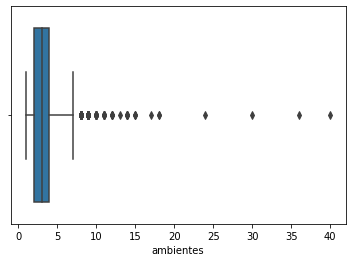

In [115]:
grf = sns.boxplot(x=df_propiedades_atipicos_test.ambientes)

Realizamos el mismo procedimiento para borrar los valores muy altos o sin sentido.

In [116]:
propiedades_a_eliminar = df_propiedades_atipicos_test[df_propiedades_atipicos_test['ambientes'] > 15]
df_propiedades_atipicos_test.drop(propiedades_a_eliminar.index, axis='rows', inplace=True)
df_precio_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)

In [117]:
propiedades_a_eliminar = df_propiedades_atipicos_test[df_propiedades_atipicos_test['habitaciones'] > 15]
df_propiedades_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)
df_precio_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)

In [118]:
propiedades_a_eliminar = df_propiedades_atipicos_test[df_propiedades_atipicos_test['habitaciones'] > df_propiedades_atipicos_test['ambientes']]
df_propiedades_atipicos_test.drop(propiedades_a_eliminar.index, axis='rows', inplace=True)
df_precio_atipicos_test.drop(propiedades_a_eliminar.index, inplace=True)

### Precio

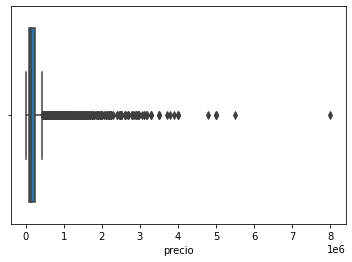

In [119]:
grf = sns.boxplot(x=df_precio_atipicos_test)

In [120]:
df_propiedades_test = df_propiedades_atipicos_test.copy()
df_propiedades_test.to_csv('df_propiedades_test.csv', index=False)

In [121]:
df_precio_test = df_precio_atipicos_test.copy()
df_precio_test.to_csv('df_precio_test.csv', index=False)

# Dataset post-procesado

## Densidades

In [122]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_precio_test = pd.read_csv('/content/df_precio_train.csv')

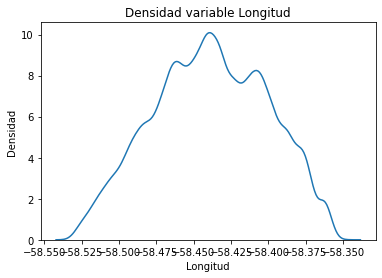

In [123]:
plt.figure(figsize=(6, 4))
grf = sns.kdeplot(data=df_propiedades_train['longitud']).set(title="Densidad variable Longitud",xlabel="Longitud",ylabel="Densidad")

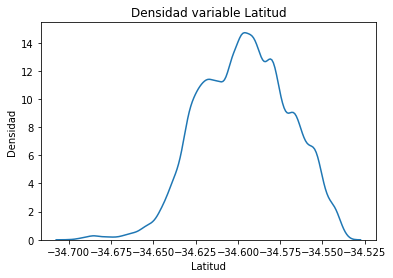

In [124]:
plt.figure(figsize=(6, 4))
grf = sns.kdeplot(data=df_propiedades_train['latitud']).set(title="Densidad variable Latitud",xlabel="Latitud",ylabel="Densidad")

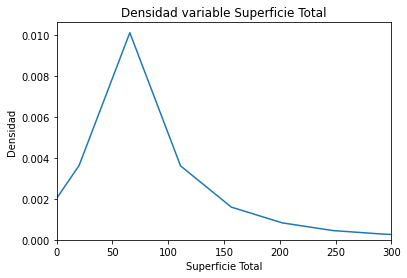

In [125]:
plt.figure(figsize=(6, 4))
grf = sns.kdeplot(data=df_propiedades_train['superficie_total']).set(title="Densidad variable Superficie Total",xlabel="Superficie Total",ylabel="Densidad", xlim=(0, 300))

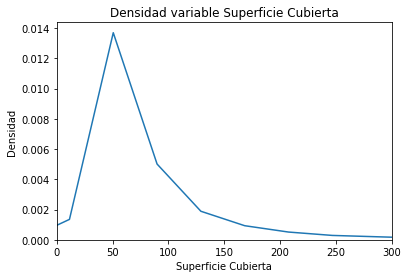

In [126]:
plt.figure(figsize=(6, 4))
grf = sns.kdeplot(data=df_propiedades_train['superficie_cubierta']).set(title="Densidad variable Superficie Cubierta",xlabel="Superficie Cubierta",ylabel="Densidad", xlim=(0, 300))

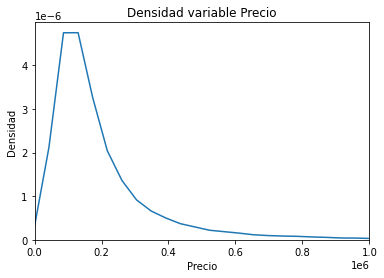

In [127]:
plt.figure(figsize=(6, 4))
grf = sns.kdeplot(data=df_precio_train).set(title="Densidad variable Precio",xlabel="Precio",ylabel="Densidad", xlim=(0, 1000000))

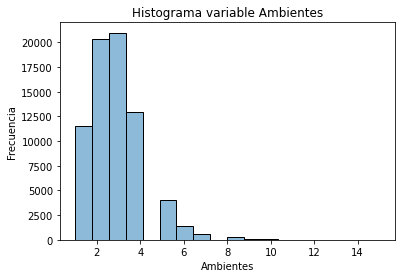

In [128]:
plt.figure(figsize=(6, 4))
sns_hist=sns.histplot(data=df_propiedades_train['ambientes'], alpha = 0.5, bins=18).set(title="Histograma variable Ambientes",xlabel="Ambientes",ylabel="Frecuencia")
plt.show()

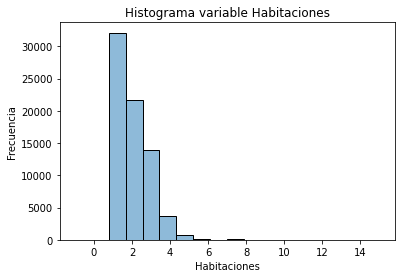

In [129]:
plt.figure(figsize=(6, 4))
sns_hist=sns.histplot(data=df_propiedades_train['habitaciones'], alpha = 0.5, bins=18).set(title="Histograma variable Habitaciones",xlabel="Habitaciones",ylabel="Frecuencia")
plt.show()

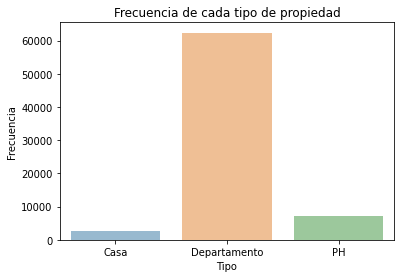

In [130]:
df_agrupado_tipo = df_propiedades_train.groupby(['tipo']).count()

eje_x = df_agrupado_tipo.index.tolist()   ## Declaramos valores para el eje x
eje_y = df_agrupado_tipo['fecha_inicio'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=df_agrupado_tipo ,alpha=0.5).set(title="Frecuencia de cada tipo de propiedad",ylabel='Frecuencia',xlabel='Tipo')

## Correlatividad

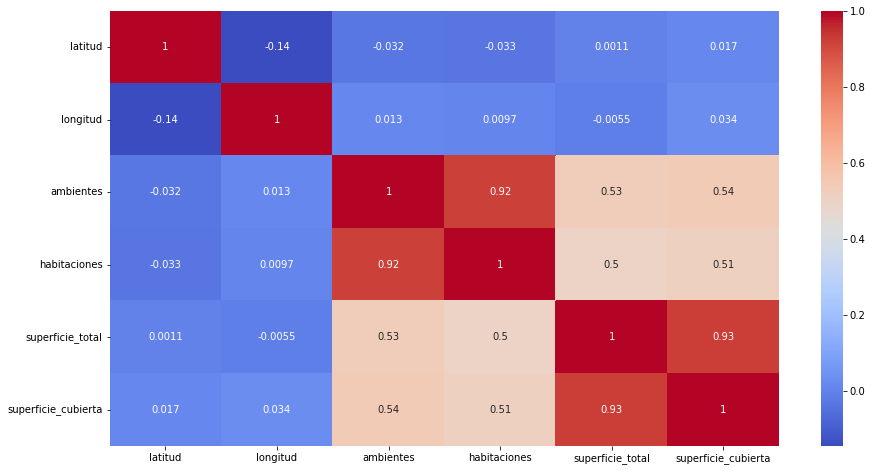

In [131]:
plt.figure(figsize = (15,8))
grf_heatmap = sns.heatmap(df_propiedades_train.corr(), annot = True, cmap='coolwarm')

# Reducción de dimensionalidad


## PCA

Para esta sección reduciremos la dimensionalidad del data set para variables que estén correlacionadas. Viendo la matriz de correlación podemos observar que la correlación entre las features 'ambientes', 'habitaciones', 'superficie_total', y 'superficie_cubierta' es considerable, por lo que es una buena idea reducir la dimensión de estas columnas para comprimir el dataset y poder graficar los datos.

Para realizar esto, primero debemos normalizar estas columnas para luego poder aplicar algoritmos de reducción de dimensionalidad.

In [132]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_precio_test = pd.read_csv('/content/df_precio_train.csv')
df_propiedades_test = pd.read_csv('/content/df_propiedades_test.csv')
df_precio_test = pd.read_csv('/content/df_precio_test.csv')

In [133]:
from sklearn.preprocessing import StandardScaler

columnas = ['ambientes', 'habitaciones', 'superficie_total', 'superficie_cubierta']

scaler = StandardScaler()
df_propiedades_train_rd_columnas = df_propiedades_train.loc[:, columnas].to_numpy()
df_propiedades_train_rd_columnas = scaler.fit_transform(df_propiedades_train_rd_columnas)

En primer lugar, podemos aplicar PCA y analizar los resultados:

In [134]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4, random_state=12)
x_transformada = pca.fit_transform(df_propiedades_train_rd_columnas)
pca_df_aux = pd.DataFrame(data = x_transformada, columns = ['cp_1', 'cp_2', 'cp_3', 'cp_4'])

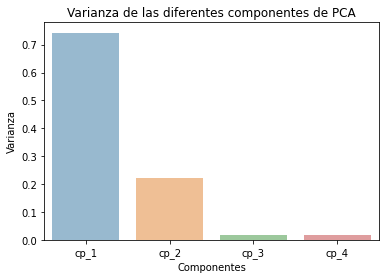

In [135]:
df_varianzas = pd.DataFrame(data=pca.explained_variance_ratio_, index = ['cp_1', 'cp_2', 'cp_3', 'cp_4'], columns=['varianza'])
eje_x = df_varianzas.index.tolist()
eje_y = df_varianzas['varianza'].tolist()

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=df_varianzas ,alpha=0.5).set(title="Varianza de las diferentes componentes de PCA",ylabel='Varianza',xlabel='Componentes')
plt.show()

La varianza de cada columna creada por PCA indica la información que retiene cada columna. Como se puede ver, la primer columna contiene la gran mayoria, seguido de la siguiente columnas. Las columnas 3 y 4 contienen muy poca información, lo que nos indica que se pueden eliminar.
Esto se puede verificar realizando un gráfico de cada eje (columna) resultante de la proyección que realiza PCA:

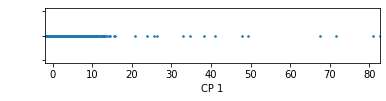

In [136]:
plt.figure(figsize=(6, 1))
x = pca_df_aux["cp_1"]
y = np.zeros_like(x)

max_cp_1 = x.max()
min_cp_1 = x.min()

plt.scatter(x, y, s=10,marker='.')
plt.xlabel(r'CP 1')
plt.yticks(color='w')
plt.xlim(min_cp_1, max_cp_1)
plt.show()

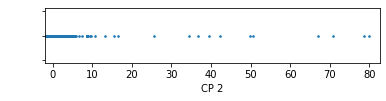

In [137]:
plt.figure(figsize=(6, 1))
x = pca_df_aux["cp_2"]
y = np.zeros_like(x)

plt.scatter(x, y, s=10,marker='.')
plt.xlabel(r'CP 2')
plt.yticks(color='w')
plt.xlim(min_cp_1, max_cp_1)
plt.show()

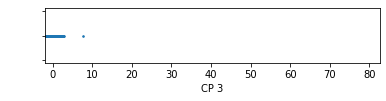

In [138]:
plt.figure(figsize=(6, 1))
x = pca_df_aux["cp_3"]
y = np.zeros_like(x)

plt.scatter(x, y, s=10,marker='.')
plt.xlabel(r'CP 3')
plt.yticks(color='w')
plt.xlim(min_cp_1, max_cp_1)
plt.show()

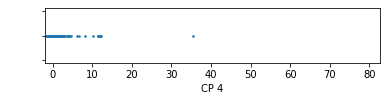

In [139]:
plt.figure(figsize=(6, 1))
x = pca_df_aux["cp_4"]
y = np.zeros_like(x)

plt.scatter(x, y, s=10,marker='.')
plt.xlabel(r'CP 4')
plt.yticks(color='w')
plt.xlim(min_cp_1, max_cp_1)
plt.show()

En las últimas dos columnas se puede apreciar que la mayoría de las observaciones están más juntas, en comparación con las primeras tres.

Por último, podemos hacer un gráfico mostrando las observaciones en las columnas restantes.

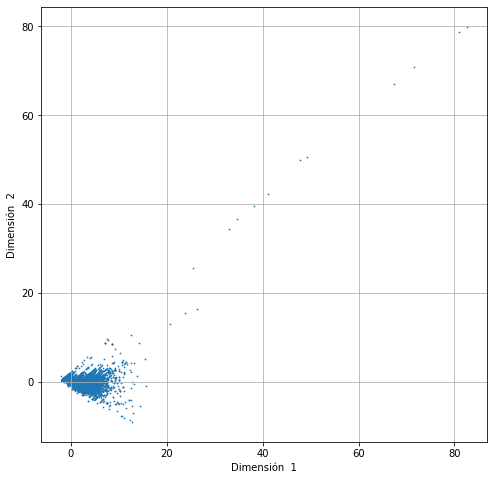

In [140]:
fig = plt.figure(figsize = (8,8))
ax= fig.add_subplot(1,1,1) 

ax.scatter(x = pca_df_aux["cp_1"], y = pca_df_aux["cp_2"], s=0.5)
ax.set_xlabel('Dimensión  1', fontsize = 10)
ax.set_ylabel('Dimensión  2', fontsize = 10)
ax.grid()

plt.show()

In [141]:
df_propiedades_train_rd_pca = df_propiedades_train.drop(columns=columnas)
df_propiedades_train_rd_pca = df_propiedades_train_rd_pca.join(pca_df_aux[["cp_1", "cp_2"]])

In [142]:
df_propiedades_train_rd_pca.to_csv("df_propiedades_train_rd_pca.csv", index=False)

In [143]:
df_propiedades_test_rd_columnas = df_propiedades_test.loc[:, columnas].to_numpy()
df_propiedades_test_rd_columnas = scaler.transform(df_propiedades_test_rd_columnas)

x_transformada = pca.transform(df_propiedades_test_rd_columnas)
pca_df_aux = pd.DataFrame(data = x_transformada, columns = ['cp_1', 'cp_2', 'cp_3', 'cp_4'])

In [144]:
df_propiedades_test_rd_pca = df_propiedades_test.drop(columns=columnas)
df_propiedades_test_rd_pca = df_propiedades_test_rd_pca.join(pca_df_aux[["cp_1", "cp_2"]])

In [145]:
df_propiedades_test_rd_pca.to_csv("df_propiedades_test_rd_pca.csv", index=False)

## t-SNE

Si bien PCA es un buen método para reducir la dimensión del dataset, es posible que querramos visualizar los datos, cosa que no es fácil de hacer con tres dimensiones. Por lo tanto, el objetivo ahora es reducir el número de dimensiones de estas columnas de cinco a dos. Para ello podríamos usar PCA, pero al eliminar la tercer columna se perderá alrededor del 10% de la información. Por esta razón utilizaremos t-SNE para realizar la reducción, considerando que es el mejor método para visualización de datos gracias al esfuerzo que realiza para mantener las distancias y los clusters de la información.
El hiperparámetro que debemos ajustar ahora es el de **perplexity**, que se relaciona con la desviación de la campana de Gauss de cada punto, la cuál es utilizada para calcular la probabilidad de sus vecinos. A mayor valor, más abarcativo será el algoritmo. Por esta razón probamos con distintos valores hasta llegar a un valor que consiga un gráfico con clusters definidos, que sea fácil de visualizar.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=300, random_state=12)
x_tsne = tsne.fit_transform(df_propiedades_train_rd_columnas)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax= fig.add_subplot(1,1,1) 

ax.scatter(x = x_tsne[:,0], y = x_tsne[:,1], s=0.5)
ax.set_xlabel('Dimensión  1', fontsize = 10)
ax.set_ylabel('Dimensión  2', fontsize = 10)
ax.grid()

plt.show()

Como se puede observar, el gráfico contiene seis (?) clusters no tan definidos, por lo que nos quedaremos con esta iteración.

In [ ]:
df_propiedades_train_rd = df_propiedades_train.copy()
df_propiedades_train_rd.drop(columns=columnas, inplace=True)

In [ ]:
df_tsne = pd.DataFrame(x_tsne, columns=["cp_1", "cp_2"])
df_propiedades_train_rd = df_propiedades_train_rd.join(df_tsne)

In [ ]:
# Exportamos el dataframe
df_propiedades_train_rd.to_csv('df_propiedades_train_rd_tsne.csv', index=False)

Realizamos lo mismo con el set de testing:

In [ ]:
# Normalizamos
df_propiedades_test_rd_columnas = df_propiedades_test.loc[:, columnas].to_numpy()
df_propiedades_test_rd_columnas = StandardScaler().fit_transform(df_propiedades_test_rd_columnas)

In [ ]:
x_tsne_test = tsne.fit_transform(df_propiedades_test_rd_columnas)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax= fig.add_subplot(1,1,1) 

ax.scatter(x = x_tsne_test[:,0], y = x_tsne_test[:,1], s=0.5)
ax.set_xlabel('Dimensión  1', fontsize = 10)
ax.set_ylabel('Dimensión  2', fontsize = 10)
ax.grid()

plt.show()

In [ ]:
df_propiedades_test_rd = df_propiedades_test.copy()
df_propiedades_test_rd.drop(columns=columnas, inplace=True)

In [ ]:
df_tsne_test = pd.DataFrame(x_tsne_test, columns=["cp_1", "cp_2"])
df_propiedades_test_rd = df_propiedades_test_rd.join(df_tsne_test)

In [ ]:
# Exportamos el dataframe
df_propiedades_test_rd.to_csv('df_propiedades_test_rd_tsne.csv', index=False)

La desventaja de t-SNE es que al ser un método no supervisado, no es posible transformar los datos del dataset de test utilizando la instancia ya entrenada de train, por lo que la única alternativa es entrenar y transformar ambos datasets completamente por separado. Los resultados obtenidos al testear este método no fueron óptimos, por lo tanto elegimos quedarnos con el dataset generado con PCA.

# Agrupamiento

Antes de comenzar, podemos utilizar la estadística de Hopkins para ver de antemano la tendencia a clustering del dataset.

In [146]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_precio_train = pd.read_csv('/content/df_precio_train.csv')
columnas = ["latitud", "longitud", "superficie_total", "superficie_cubierta", "ambientes", "habitaciones"]
df_propiedades_train_kmeans = df_propiedades_train[columnas].join(df_precio_train)

In [147]:
df_propiedades_train_kmeans.dropna(inplace=True)

In [148]:
 score = hopkins(df_propiedades_train_kmeans, df_propiedades_train_kmeans.shape[0])
 print(f'Estadística de Hopkins: {score}')

Estadística de Hopkins: 0.0004212837628306388


El valor obtenido es muy bajo, lo que significa que el dataset no tiene mucha tendencia a poder dividirse en clusters. Sin embargo, podemos intentar calcular los clusters resultantes usando K-Means.

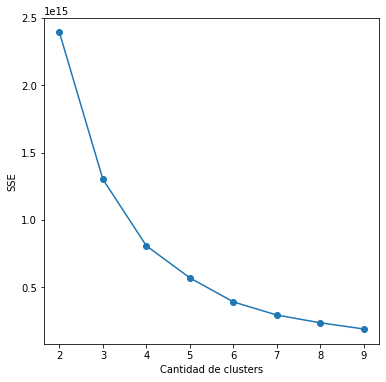

In [149]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=12)
    km.fit(df_propiedades_train_kmeans)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

La _incercia_ resultante de KMeans es una medida de que tan lejanos están los puntos de cada cluster con los demás puntos de su mismo cluster. Mientras menor sea esta métrica, mejor serán los  clusters. Sin embargo, al aumentar el número de clusters se pierde la representatividad de cada cluster. En el gráfico anterior no se puede ver claramente un número que actúe como 'codo', pero se puede ver que 4 es un buen número de clusters, dado que los valores anteriores tienen mucha inercia, y los valores posteriores pierden inercia pero a una tasa mucho menor. 

Como siguiente paso, calcularemos el score de silhouette, que nos dará una métrica de que tan definidos son los clusters elegidos:

In [150]:
km = KMeans(n_clusters=4, random_state=12)
clusters = km.fit_predict(df_propiedades_train_kmeans)

In [151]:
score = silhouette_score(df_propiedades_train_kmeans, clusters)
print(f"Silhouette score: {score}")

Silhouette score: 0.7047964322481803


También se puede realizar un gráfico, para ver como se comparan los valores de silhouette entre los diferentes clusters. 

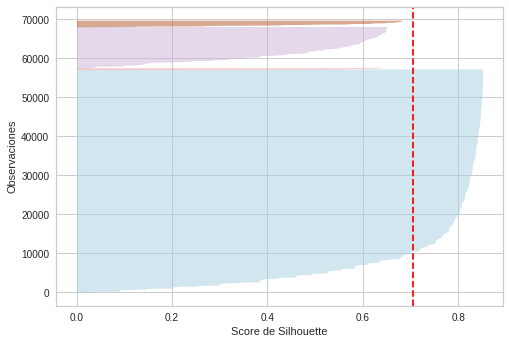

In [152]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(km, colors='Paired', random_state=12)    # Instancio el visualizador
visualizer.fit(df_propiedades_train_kmeans)
plt.xlabel("Score de Silhouette")
plt.ylabel("Observaciones")
plt.show()

El resultado es un cluster que está muy bien definido acorde al score que recibe, y tres clusters que están completamente debajo del score de Silhouette promedio del dataset, por lo que su calidad será mucho menor. Esto tiene sentido, debido al análisis de la estadística de Hopkins realizado anteriormente.

Por último, podemos ver los centros de cada cluster para conocer los valores más representativos de cada uno.

In [153]:
centros = pd.DataFrame(km.cluster_centers_, columns=columnas + ['precio'])
centros.precio = centros.precio.astype('int64')
centros

,latitud,longitud,superficie_total,superficie_cubierta,ambientes,habitaciones,precio
0,-34.598335,-58.440852,69.963189,58.586409,2.487712,1.652271,135758
1,-34.582169,-58.405092,437.191846,389.099500,5.968208,3.783237,2863829
2,-34.587523,-58.432361,169.442890,141.439997,4.170408,2.927915,438395
3,-34.582884,-58.412499,296.718241,257.336434,5.105496,3.384081,1209639


Podemos observar a partir de estos valores, que el primer cluster se compone de propiedades de bajo precio, con poca superficie y pocos ambientes. El segundo cluster tiene una mayor cantidad de habitaciones, y tiene una superficie mucho mayor. Además tiene un precio promedio casi diez veces mayor que el primer cluster.
El tercer cluster, en cambio, es un tipo de propiedad que se encuentra entre el tercer y primer cluster. Por último, el cluster 4 tiene un precio mucho mayor, y la mayor superficie.

## KMeans con 3 grupos

Podemos realizar el mismo análisis con 3 clusters:

In [154]:
km_3 = KMeans(n_clusters=3, random_state=12)
clusters_3 = km_3.fit_predict(df_propiedades_train_kmeans)

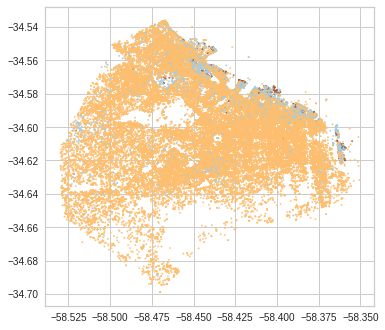

In [155]:
df_propiedades_train_kmeans.loc[:, "grupo"] = clusters_3
gdf = geopandas.GeoDataFrame(df_propiedades_train_kmeans, geometry=geopandas.points_from_xy(df_propiedades_train_kmeans['longitud'], df_propiedades_train_kmeans['latitud']))
gdf.plot(column="grupo", cmap='Paired', markersize=2)
plt.show()

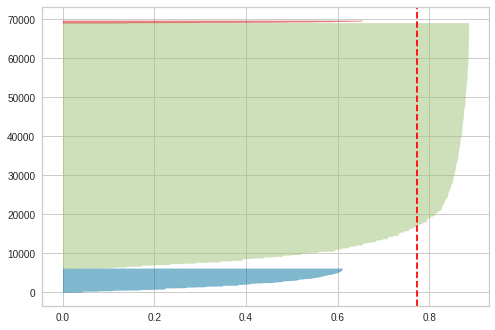

In [158]:
km = KMeans(n_clusters=3, random_state=12)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', random_state=12)    # Instancio el visualizador
df_propiedades_train_kmeans.drop(columns="geometry", inplace=True)
visualizer.fit(df_propiedades_train_kmeans)
plt.show()

# Clasificación

## Tipo de precio

In [159]:
df_propiedades_train_clasificacion = pd.read_csv('/content/df_propiedades_train.csv')
df_precio_train = pd.read_csv('/content/df_precio_train.csv')
df_propiedades_test_clasificacion = pd.read_csv('/content/df_propiedades_test.csv')
df_precio_test = pd.read_csv('/content/df_precio_test.csv')

In [160]:
df_propiedades_train_clasificacion.loc[:, 'precio'] = df_precio_train
df_propiedades_test_clasificacion.loc[:, 'precio'] = df_precio_test

In [161]:
df_precio_por_m2_train = df_propiedades_train_clasificacion['precio'] // df_propiedades_train_clasificacion["superficie_total"]
df_precio_por_m2_test = df_propiedades_test_clasificacion['precio'] // df_propiedades_test_clasificacion["superficie_total"]

labels = ["bajo", "medio", "alto"]

### Distribución de precio por metro cuadrado

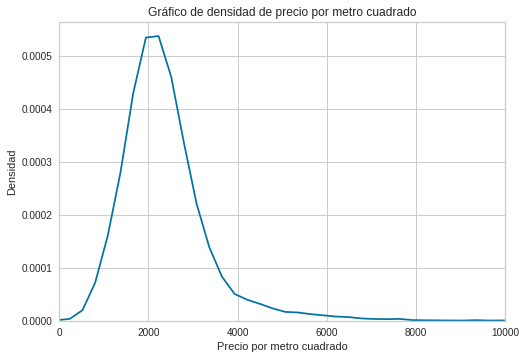

In [162]:
grf_precio_por_m2 = sns.kdeplot(data=df_precio_por_m2_train).set(title="Gráfico de densidad de precio por metro cuadrado",xlabel="Precio por metro cuadrado",ylabel="Densidad", xlim=(0, 10000))

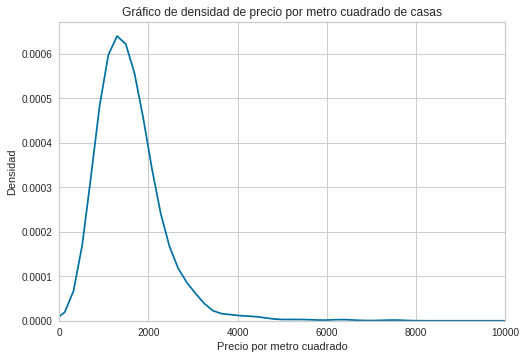

In [163]:
grf_precio_por_m2_casas = sns.kdeplot(data=df_precio_por_m2_train.loc[df_propiedades_train_clasificacion["tipo"] == "Casa"]).set(title="Gráfico de densidad de precio por metro cuadrado de casas",xlabel="Precio por metro cuadrado",ylabel="Densidad", xlim=(0, 10000))

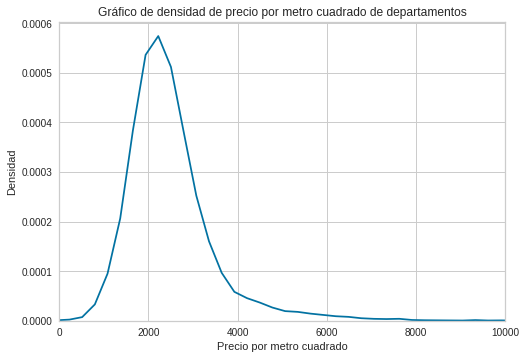

In [164]:
grf_precio_por_m2_departamentos = sns.kdeplot(data=df_precio_por_m2_train.loc[df_propiedades_train_clasificacion["tipo"] == "Departamento"]).set(title="Gráfico de densidad de precio por metro cuadrado de departamentos",xlabel="Precio por metro cuadrado",ylabel="Densidad", xlim=(0, 10000))

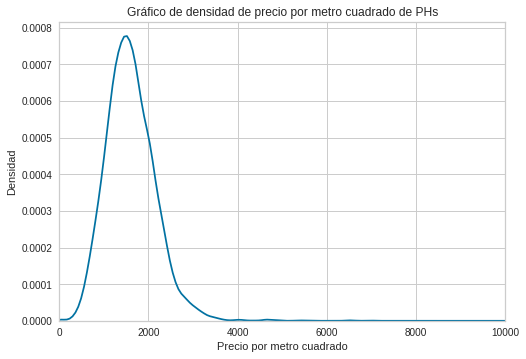

In [165]:
grf_precio_por_m2_phs = sns.kdeplot(data=df_precio_por_m2_train.loc[df_propiedades_train_clasificacion["tipo"] == "PH"]).set(title="Gráfico de densidad de precio por metro cuadrado de PHs",xlabel="Precio por metro cuadrado",ylabel="Densidad", xlim=(0, 10000))

### Primer alternativa

In [166]:
df_tipo_precio_primer_alternativa = pd.qcut(df_precio_por_m2_train, q=3, labels=labels)

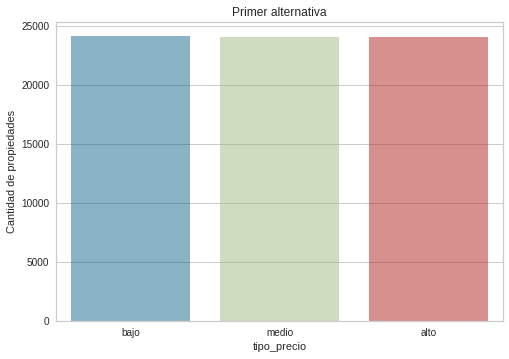

In [167]:
df_aux = pd.DataFrame(df_tipo_precio_primer_alternativa, columns=['tipo_precio']).join(df_propiedades_train_clasificacion['tipo'])
df_agrupado_tipo_precio = df_aux.groupby(['tipo_precio']).count()

eje_x = df_agrupado_tipo_precio.index.tolist()   ## Declaramos valores para el eje x
eje_y = df_agrupado_tipo_precio['tipo'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=df_agrupado_tipo_precio ,alpha=0.5).set(title="Primer alternativa",ylabel='Cantidad de propiedades',xlabel='tipo_precio')
plt.show()

In [168]:
# Creo la nueva variable en el dataset de testeo, usando los límites ya seteados por train.
limite_bajo = max(df_precio_por_m2_train.loc[df_tipo_precio_primer_alternativa == 'bajo'])
limite_medio = max(df_precio_por_m2_train.loc[df_tipo_precio_primer_alternativa == 'medio'])

In [169]:
df_aux = df_propiedades_test_clasificacion.copy()
df_aux.loc[df_precio_por_m2_test <= limite_bajo, 'tipo_precio'] = 'bajo'
df_aux.loc[(df_precio_por_m2_test > limite_bajo) & (df_precio_por_m2_test <= limite_medio), 'tipo_precio'] = 'medio'
df_aux.loc[df_precio_por_m2_test > limite_medio, 'tipo_precio'] = 'alto'

In [170]:
df_tipo_precio_primer_alternativa_test = df_aux.tipo_precio.copy()

### Segunda alternativa

In [171]:
df_tipo_precio_segunda_alternativa = pd.qcut(df_precio_por_m2_train,q=[0,0.25,0.75,1], labels=labels)

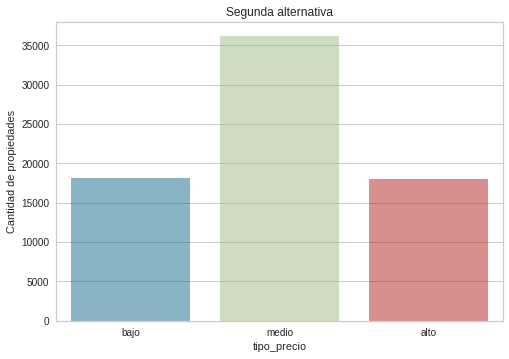

In [172]:
df_aux = pd.DataFrame(df_tipo_precio_segunda_alternativa, columns=['tipo_precio']).join(df_propiedades_train_clasificacion['tipo'])
df_agrupado_tipo_precio = df_aux.groupby(['tipo_precio']).count()

eje_x = df_agrupado_tipo_precio.index.tolist()   ## Declaramos valores para el eje x
eje_y = df_agrupado_tipo_precio['tipo'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=df_agrupado_tipo_precio ,alpha=0.5).set(title="Segunda alternativa",ylabel='Cantidad de propiedades',xlabel='tipo_precio')
plt.show()

In [173]:
# Creo la nueva variable en el dataset de testeo, usando los límites ya seteados por train.
limite_bajo = max(df_precio_por_m2_train.loc[df_tipo_precio_segunda_alternativa == 'bajo'])
limite_medio = max(df_precio_por_m2_train.loc[df_tipo_precio_segunda_alternativa == 'medio'])

In [174]:
df_aux = df_propiedades_test_clasificacion.copy()
df_aux.loc[df_precio_por_m2_test <= limite_bajo, 'tipo_precio'] = 'bajo'
df_aux.loc[(df_precio_por_m2_test > limite_bajo) & (df_precio_por_m2_test <= limite_medio), 'tipo_precio'] = 'medio'
df_aux.loc[df_precio_por_m2_test > limite_medio, 'tipo_precio'] = 'alto'

In [175]:
df_tipo_precio_segunda_alternativa_test = df_aux.tipo_precio.copy()

### Tercer alternativa

In [176]:
df_propiedades_tercer_alternativa = df_propiedades_train_clasificacion.join(pd.Series(df_precio_por_m2_train, name='precio_por_m2'))

In [177]:
df_propiedades_tercer_alternativa.loc[df_propiedades_tercer_alternativa["tipo"] == "Casa", "tipo_precio"] = pd.qcut(df_propiedades_tercer_alternativa.loc[df_propiedades_tercer_alternativa["tipo"] == "Casa", "precio_por_m2"], q=[0,0.25,0.75,1], labels=labels)
df_propiedades_tercer_alternativa.loc[df_propiedades_tercer_alternativa["tipo"] == "Departamento", "tipo_precio"] = pd.qcut(df_propiedades_tercer_alternativa.loc[df_propiedades_tercer_alternativa["tipo"] == "Departamento", "precio_por_m2"], q=[0,0.25,0.75,1], labels=labels)
df_propiedades_tercer_alternativa.loc[df_propiedades_tercer_alternativa["tipo"] == "PH", "tipo_precio"] = pd.qcut(df_propiedades_tercer_alternativa.loc[df_propiedades_tercer_alternativa["tipo"] == "PH", "precio_por_m2"], q=[0,0.25,0.75,1], labels=labels)

In [178]:
df_tipo_precio_tercer_alternativa = df_propiedades_tercer_alternativa['tipo_precio'].copy()

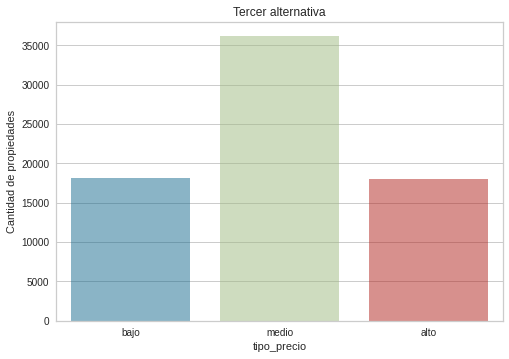

In [179]:
df_agrupado_tipo_precio = df_propiedades_tercer_alternativa.groupby(['tipo_precio']).count()

eje_x = df_agrupado_tipo_precio.index.tolist()   ## Declaramos valores para el eje x
eje_y = df_agrupado_tipo_precio['tipo'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=df_agrupado_tipo_precio ,alpha=0.5).set(title="Tercer alternativa",ylabel='Cantidad de propiedades',xlabel='tipo_precio')
plt.show()

In [180]:
# Creo la nueva variable en el dataset de testeo, usando los límites ya seteados por train para cada tipo de propiedad.
limite_bajo_casa = max(df_precio_por_m2_train.loc[(df_tipo_precio_tercer_alternativa == 'bajo') & (df_propiedades_tercer_alternativa["tipo"] == "Casa")])
limite_medio_casa = max(df_precio_por_m2_train.loc[(df_tipo_precio_tercer_alternativa == 'medio') & (df_propiedades_tercer_alternativa["tipo"] == "Casa")])

limite_bajo_departamento = max(df_precio_por_m2_train.loc[(df_tipo_precio_tercer_alternativa == 'bajo') & (df_propiedades_tercer_alternativa["tipo"] == "Departamento")])
limite_medio_departamento = max(df_precio_por_m2_train.loc[(df_tipo_precio_tercer_alternativa == 'medio') & (df_propiedades_tercer_alternativa["tipo"] == "Departamento")])

limite_bajo_ph = max(df_precio_por_m2_train.loc[(df_tipo_precio_tercer_alternativa == 'bajo') & (df_propiedades_tercer_alternativa["tipo"] == "PH")])
limite_medio_ph = max(df_precio_por_m2_train.loc[(df_tipo_precio_tercer_alternativa == 'medio') & (df_propiedades_tercer_alternativa["tipo"] == "PH")])

In [181]:
df_aux = df_propiedades_test_clasificacion.copy()
df_aux.loc[(df_precio_por_m2_test <= limite_bajo_casa) & (df_propiedades_test_clasificacion['tipo'] == 'Casa'), 'tipo_precio'] = 'bajo'
df_aux.loc[(df_precio_por_m2_test > limite_bajo_casa) & (df_precio_por_m2_test <= limite_medio_casa) & (df_propiedades_test_clasificacion['tipo'] == 'Casa'), 'tipo_precio'] = 'medio'
df_aux.loc[(df_precio_por_m2_test > limite_medio_casa) & (df_propiedades_test_clasificacion['tipo'] == 'Casa'), 'tipo_precio'] = 'alto'

df_aux.loc[(df_precio_por_m2_test <= limite_bajo_departamento) & (df_propiedades_test_clasificacion['tipo'] == 'Departamento'), 'tipo_precio'] = 'bajo'
df_aux.loc[(df_precio_por_m2_test > limite_bajo_departamento) & (df_precio_por_m2_test <= limite_medio_departamento) & (df_propiedades_test_clasificacion['tipo'] == 'Departamento'), 'tipo_precio'] = 'medio'
df_aux.loc[(df_precio_por_m2_test > limite_medio_departamento) & (df_propiedades_test_clasificacion['tipo'] == 'Departamento'), 'tipo_precio'] = 'alto'

df_aux.loc[(df_precio_por_m2_test <= limite_bajo_ph) & (df_propiedades_test_clasificacion['tipo'] == 'PH'), 'tipo_precio'] = 'bajo'
df_aux.loc[(df_precio_por_m2_test > limite_bajo_ph) & (df_precio_por_m2_test <= limite_medio_ph) & (df_propiedades_test_clasificacion['tipo'] == 'PH'), 'tipo_precio'] = 'medio'
df_aux.loc[(df_precio_por_m2_test > limite_medio_ph) & (df_propiedades_test_clasificacion['tipo'] == 'PH'), 'tipo_precio'] = 'alto'

In [182]:
df_tipo_precio_tercer_alternativa_test = df_aux.tipo_precio.copy()

### Decisión

Justificación:

 - Tiene sentido que las casas sean caras

In [183]:
df_tipo_precio_train = df_tipo_precio_segunda_alternativa.copy()
df_tipo_precio_test = df_tipo_precio_segunda_alternativa_test.copy()

In [184]:
df_tipo_precio_train.to_csv('df_tipo_precio_train.csv', index=False)
df_tipo_precio_test.to_csv('df_tipo_precio_test.csv', index=False)

## Modelo 1: Árbol de decisión

In [185]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_tipo_precio_train = pd.read_csv('/content/df_tipo_precio_train.csv')
df_propiedades_test = pd.read_csv('/content/df_propiedades_test.csv')
df_tipo_precio_test = pd.read_csv('/content/df_tipo_precio_test.csv')

### Feature engineering

In [189]:
columnas_para_dummies = ["tipo", "barrio"]
columnas_a_eliminar = ["fecha_inicio", "fecha_fin"]
x_train_arbol = pd.get_dummies(df_propiedades_train, columns = columnas_para_dummies, drop_first=True)
x_test_arbol = pd.get_dummies(df_propiedades_test, columns = columnas_para_dummies, drop_first=True)
x_train_arbol.drop(columns = columnas_a_eliminar, inplace=True)
x_test_arbol.drop(columns = columnas_a_eliminar, inplace=True)

# Se eliminan los datos NA de longitud y latitud
x_train_arbol.dropna(inplace=True)
x_test_arbol.dropna(inplace=True)
y_train = df_tipo_precio_train.loc[x_train_arbol.index].copy()
y_test = df_tipo_precio_test.loc[x_test_arbol.index].copy()

### Modelo

Elegimos recall porque nos interesa predecir correctamente la mayor cantidad de propiedades. En este caso, nos interesa la predicción a nivel global, sin priorizar ninguna categoría por sobre otra. Por lo tanto, elegimos el parámetro 'micro' para nuestro scorer.

[Documentación Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)


In [190]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn import tree
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
import sklearn as sk

In [191]:
arbolcv = tree.DecisionTreeClassifier()

n = 20

params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0.001,0.05,n), 
               'max_depth':list(range(14,20)),
               'random_state': [12]}

scorer = make_scorer(sk.metrics.recall_score, average = 'micro')

kfoldcv = StratifiedKFold(n_splits=20)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = arbolcv,
                              param_distributions = params_grid,
                              scoring = scorer,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state = 12) 

#Busco los hiperparamtros que optimizan recall
randomcv.fit(x_train_arbol, y_train);

In [192]:
randomcv.best_params_

{'random_state': 12,
 'max_depth': 15,
 'criterion': 'entropy',
 'ccp_alpha': 0.001}

In [193]:
#Creo árbol con los mejores hiperparámetros 
arbolcv=tree.DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Hago CV
resultados = cross_validate(estimator = arbolcv,
                            X = x_train_arbol,
                            y = y_train,
                            cv = kfoldcv,
                            scoring = scorer,
                            return_estimator=True)
#Selecciono el arbol con mejor performance
metricsCV = resultados['test_score']
mejor_arbol = resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]


In [194]:
score_train = max(resultados['test_score'])

In [195]:
model = mejor_arbol.fit(X = x_train_arbol, y = y_train)
y_pred = model.predict(x_test_arbol)

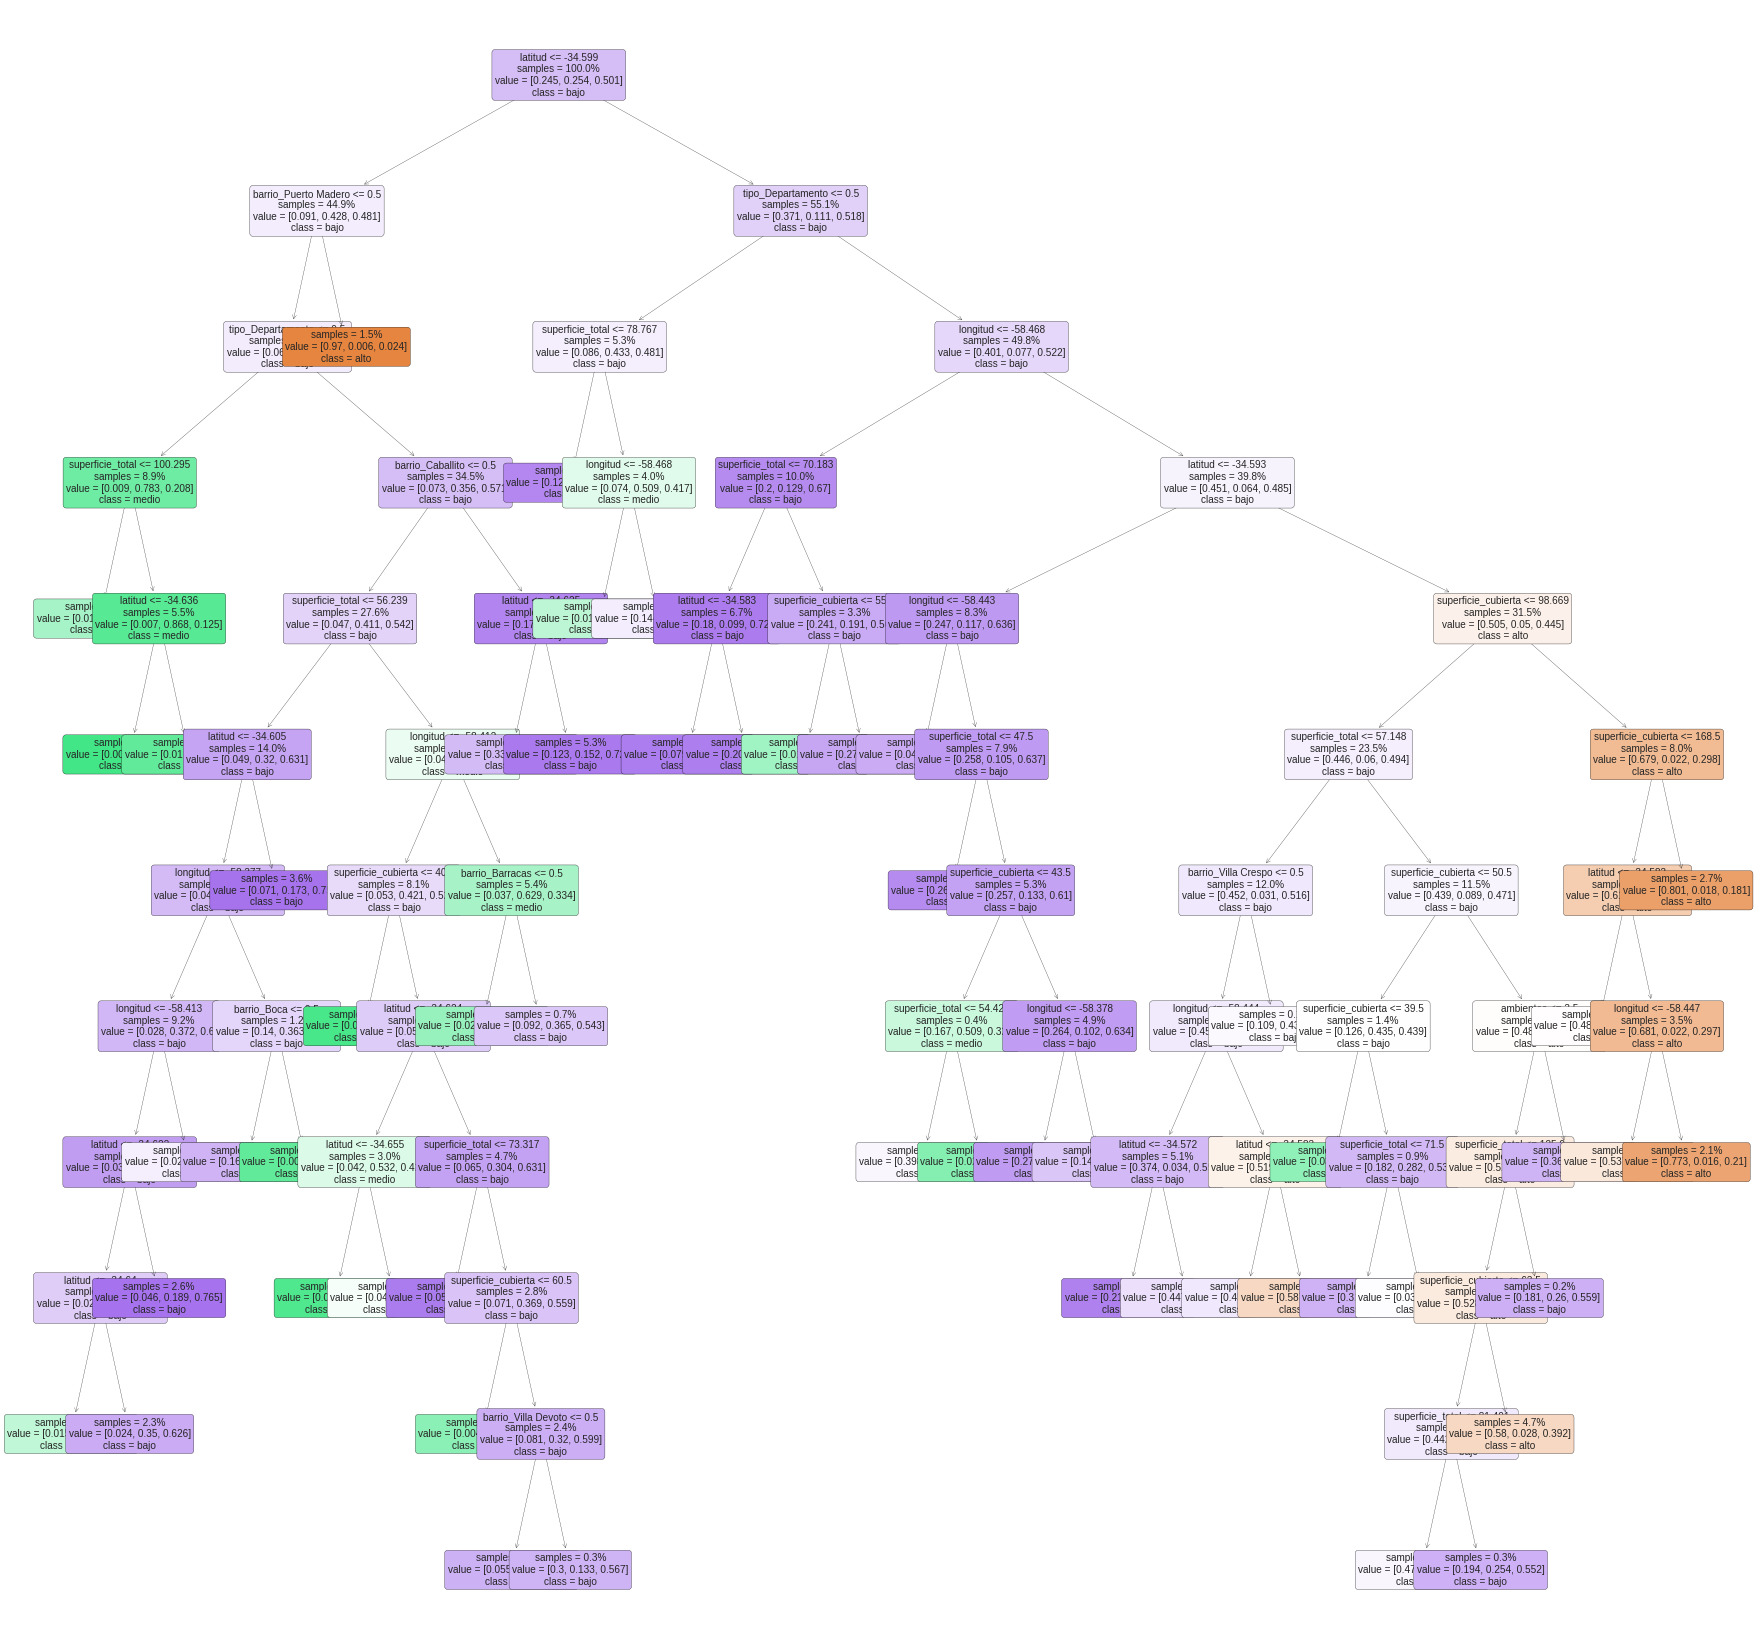

In [196]:
plt.figure(figsize=(30,30))

tree_plot=tree.plot_tree(model,
                         max_depth=20,
                         feature_names=x_train_arbol.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=["alto", "medio", "bajo"],
                         proportion = True,
                         fontsize = 10,
                         impurity = False)

plt.show(tree_plot)

Como primer decisión, el árbol resultante divide las observaciones según latitud. Es decir, entre norte y sur, debido a que la ubicación geogáfica de cada propiedad afecta su precio.

En el caso en el que la propiedad se encuentre en la parte sur de la ciudad, el árbol pasa a evaluar si esta está en Puerto Madero. En el caso de que sí lo esté, inmediatamente clasifica a la propiedad como de precio alto.

Por otro lado, si la propiedad está del lado norte, pasa a preguntar si es de tipo departamento. El tipo de propiedad afecta el precio considerablemente por lo visto en el análisis hecho previamente de sus cuartiles. 

In [197]:
columnas = x_train_arbol.columns.to_list()
df_importancia_features = pd.Series(mejor_arbol.feature_importances_, index = columnas)

In [198]:
df_importancia_features_aux = df_importancia_features[df_importancia_features > 0]

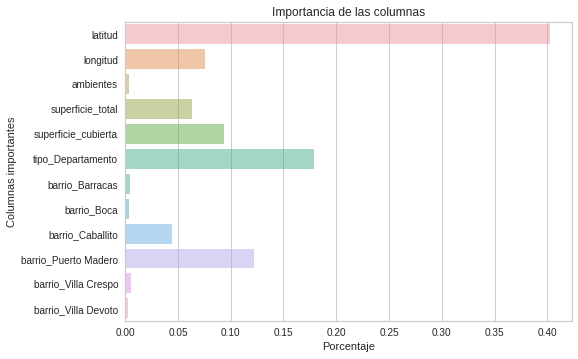

In [199]:
eje_y = df_importancia_features_aux.index.tolist()
eje_x = df_importancia_features_aux.tolist()

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y ,alpha=0.5, orient="h").set(title="Importancia de las columnas",xlabel='Porcentaje',ylabel='Columnas importantes')

El gráfico superior es consecuente con el análisis del árbol realizado previamente, ya que la primera decisión que toma es en base a la columna más importante. En general, las columnas que más afectan el árbol de decisión son aquellas relacionadas con la ubicación geográfica de la propiedad.

### Evaluación

Text(51.0, 0.5, 'True')

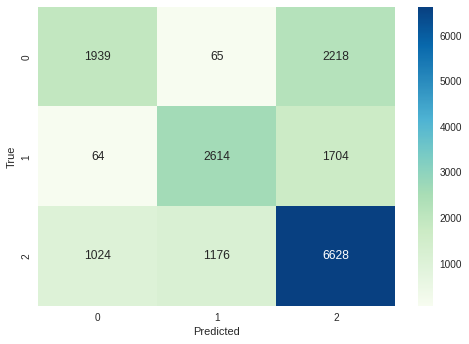

In [200]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Al observar la matriz de confusión, podemos apreciar que la diagonal concentra la mayor cantidad de propiedades. Esto nos lleva a pensar que el modelo predice de manera aceptable. Debajo podemos rectificar con el recall score:

In [201]:
recall_ad = recall_score(y_test, y_pred, average='micro')
print(f"Recall del dataset de evaluación: {round(recall_ad, 4)}")
print(f"Recall obtenido luego de entrenar el modelo: {round(score_train, 4)}")

Recall del dataset de evaluación: 0.6414
Recall obtenido luego de entrenar el modelo: 0.6601


Los valores obtenidos de recall score son parecidos, lo que sugiere que el modelo está ajustandose bien (no hay underfitting, ni overfitting).

### Modelo con reducción de dimensionalidad

In [222]:
df_propiedades_train_rd = pd.read_csv('/content/df_propiedades_train.csv')
df_tipo_precio_train = pd.read_csv('/content/df_tipo_precio_train.csv')
df_propiedades_test_rd = pd.read_csv('/content/df_propiedades_test.csv')
df_tipo_precio_test = pd.read_csv('/content/df_tipo_precio_test.csv')

#### Feature engineering

In [223]:
columnas_para_dummies = ["tipo", "barrio"]
columnas_a_eliminar = ["fecha_inicio", "fecha_fin"]
x_train_arbol = pd.get_dummies(df_propiedades_train_rd, columns = columnas_para_dummies, drop_first=True)
x_test_arbol = pd.get_dummies(df_propiedades_test_rd, columns = columnas_para_dummies, drop_first=True)
x_train_arbol.drop(columns = columnas_a_eliminar, inplace=True)
x_test_arbol.drop(columns = columnas_a_eliminar, inplace=True)
x_train_arbol.dropna(inplace=True)
x_test_arbol.dropna(inplace=True)
y_train = df_tipo_precio_train.loc[x_train_arbol.index].copy()
y_test = df_tipo_precio_test.loc[x_test_arbol.index].copy()

#### Modelo

In [224]:
arbolcv = tree.DecisionTreeClassifier()

n = 20

params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0.001,0.05,n), 
               'max_depth':list(range(14,20)),
               'random_state': [12]}

scorer = make_scorer(sk.metrics.recall_score, average = 'micro')

kfoldcv = StratifiedKFold(n_splits=20)

#Random Search Cross Validation
randomcv_arbol = RandomizedSearchCV(estimator = arbolcv,
                              param_distributions = params_grid,
                              scoring = scorer,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state = 12) 

#Busco los hiperparamtros que optimizan recall
randomcv_arbol.fit(x_train_arbol, y_train);

In [225]:
#Creo árbol con los mejores hiperparámetros
arbolcv=tree.DecisionTreeClassifier().set_params(**randomcv_arbol.best_params_)

#Hago CV
resultados = cross_validate(estimator = arbolcv,
                            X = x_train_arbol,
                            y = y_train,
                            cv = kfoldcv,
                            scoring = scorer,
                            return_estimator=True)
#Selecciono el arbol con mejor performance
metricsCV = resultados['test_score']
mejor_arbol_rd = resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]


In [226]:
score_train = max(resultados['test_score'])

In [227]:
mejor_arbol_rd.fit(X = x_train_arbol, y = y_train)
y_pred = mejor_arbol_rd.predict(x_test_arbol)

#### Evaluación

Text(51.0, 0.5, 'True')

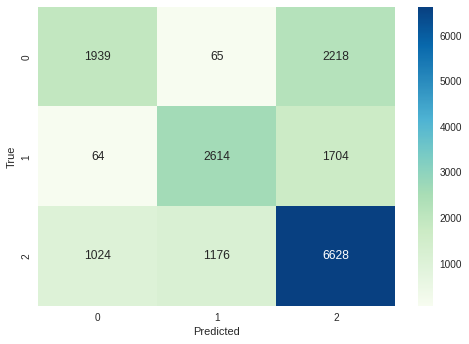

In [209]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [210]:
recall_ad_rd = recall_score(y_test, y_pred, average='micro')
print(f"Recall del dataset de evaluación: {round(recall_ad_rd, 4)}")
print(f"Recall obtenido luego de entrenar el modelo: {round(score_train, 4)}")

Recall del dataset de evaluación: 0.6414
Recall obtenido luego de entrenar el modelo: 0.6601


## Modelo 2: Random Forest

In [234]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

x_train_rf = pd.read_csv('/content/df_propiedades_train.csv')
y_train = pd.read_csv('/content/df_tipo_precio_train.csv')
x_test_rf = pd.read_csv('/content/df_propiedades_test.csv')
y_test = pd.read_csv('/content/df_tipo_precio_test.csv')

columnas_para_dummies = ["tipo", "barrio"]
columnas_a_eliminar = ["fecha_inicio", "fecha_fin"]
x_train_rf = pd.get_dummies(df_propiedades_train, columns = columnas_para_dummies, drop_first=True)
x_test_rf = pd.get_dummies(df_propiedades_test, columns = columnas_para_dummies, drop_first=True)
x_train_rf.drop(columns = columnas_a_eliminar, inplace=True)
x_test_rf.drop(columns = columnas_a_eliminar, inplace=True)

# Se eliminan los datos NA de longitud y latitud
x_train_rf.dropna(inplace=True)
x_test_rf.dropna(inplace=True)
y_train = df_tipo_precio_train.loc[x_train_rf.index].copy()
y_test = df_tipo_precio_test.loc[x_test_rf.index].copy()

In [235]:
# Ya tengo los mejores parámetros que fueron obtenidos en el Modelo anterior

rf = RandomForestClassifier(n_estimators = 100).set_params(**randomcv_arbol.best_params_) 
rf.fit(x_train_rf, y_train)
y_pred = rf.predict(x_test_rf)

precision_rf = metrics.accuracy_score(y_test, y_pred)
recall_rf = metrics.recall_score(y_test, y_pred, average='micro')

print("PRECISION: ", precision_rf)
print("RECALL: ", recall_rf)

PRECISION:  0.6443896282698486
RECALL:  0.6443896282698486


## Modelo 3: Regresión Logística

In [238]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_tipo_precio_train = pd.read_csv('/content/df_tipo_precio_train.csv')
df_propiedades_test = pd.read_csv('/content/df_propiedades_test.csv')
df_tipo_precio_test = pd.read_csv('/content/df_tipo_precio_test.csv')

In [239]:
columnas_para_dummies = ["tipo", "barrio"]
columnas_a_eliminar = ["fecha_inicio", "fecha_fin"]
x_train_rl = pd.get_dummies(df_propiedades_train, columns = columnas_para_dummies, drop_first=True)
x_test_rl = pd.get_dummies(df_propiedades_test, columns = columnas_para_dummies, drop_first=True)
x_train_rl.drop(columns = columnas_a_eliminar, inplace=True)
x_test_rl.drop(columns = columnas_a_eliminar, inplace=True)

# Se eliminan los datos NA de longitud y latitud
x_train_rl.dropna(inplace=True)
x_test_rl.dropna(inplace=True)
y_train = df_tipo_precio_train.loc[x_train_rl.index].copy()
y_test = df_tipo_precio_test.loc[x_test_rl.index].copy()

In [240]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
import sklearn as sk
from scipy.stats import uniform

In [241]:
logistic_regression = LogisticRegression()

logistic_regression.get_params().keys()

params_grid = {'penalty': ['l1', 'l2'],
               'solver': ['liblinear'],
               'C': uniform(loc=0.8, scale=0.4),
               'random_state': [12]
               }

scorer = make_scorer(sk.metrics.recall_score, average = 'micro')

kfoldcv = StratifiedKFold(n_splits=20)

# Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = logistic_regression,
                             param_distributions = params_grid,
                              scoring = scorer,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state = 12)

# Busco los hiperparamtros que optimizan recall
randomcv.fit(x_train_rl, y_train);

KeyboardInterrupt: ignored

In [ ]:
rl = LogisticRegression().set_params(**randomcv.best_params_)

#Hago CV
resultados = cross_validate(estimator = rl,
                            X = x_train_rl,
                            y = y_train,
                            cv = kfoldcv,
                            scoring = scorer,
                            return_estimator=True)
#Selecciono el arbol con mejor performance
metricsCV = resultados['test_score']
mejor_rl = resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

In [ ]:
score_train = max(resultados['test_score'])

In [ ]:
mejor_rl.fit(X = x_train_rl, y = y_train)
y_pred = mejor_rl.predict(x_test_rl)

### Evaluación

In [ ]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
recall_rl = recall_score(y_test, y_pred, average='micro')
print(f"Recall del dataset de evaluación: {round(recall_rl, 4)}")
print(f"Recall obtenido luego de entrenar el modelo: {round(score_train, 4)}")

### Reducción dimensionalidad

In [ ]:
df_propiedades_train_rd_pca = pd.read_csv('/content/df_propiedades_train_rd_pca.csv')
df_tipo_precio_train = pd.read_csv('/content/df_tipo_precio_train.csv')
df_propiedades_test_rd_pca = pd.read_csv('/content/df_propiedades_test_rd_pca.csv')
df_tipo_precio_test = pd.read_csv('/content/df_tipo_precio_test.csv')

In [ ]:
columnas_para_dummies = ["tipo", "barrio"]
columnas_a_eliminar = ["fecha_inicio", "fecha_fin"]
x_train_arbol = pd.get_dummies(df_propiedades_train_rd_pca, columns = columnas_para_dummies, drop_first=True)
x_test_arbol = pd.get_dummies(df_propiedades_test_rd_pca, columns = columnas_para_dummies, drop_first=True)
x_train_arbol.drop(columns = columnas_a_eliminar, inplace=True)
x_test_arbol.drop(columns = columnas_a_eliminar, inplace=True)

# Se eliminan los datos NA de longitud y latitud
x_train_arbol.dropna(inplace=True)
x_test_arbol.dropna(inplace=True)
y_train = df_tipo_precio_train.loc[x_train_arbol.index].copy()
y_test = df_tipo_precio_test.loc[x_test_arbol.index].copy()

In [ ]:
logistic_regression = LogisticRegression()

logistic_regression.get_params().keys()

params_grid = {'penalty': ['l1', 'l2'],
               'solver': ['liblinear'],
               'C': uniform(loc=0.8, scale=0.4),
               'random_state': [12]
               }

scorer = make_scorer(sk.metrics.recall_score, average = 'micro')

kfoldcv = StratifiedKFold(n_splits=20)

# Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = logistic_regression,
                             param_distributions = params_grid,
                              scoring = scorer,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state = 12)

# Busco los hiperparamtros que optimizan recall
randomcv.fit(x_train_arbol, y_train);

In [ ]:
rl = LogisticRegression().set_params(**randomcv.best_params_)

#Hago CV
resultados = cross_validate(estimator = rl,
                            X = x_train_arbol,
                            y = y_train,
                            cv = kfoldcv,
                            scoring = scorer,
                            return_estimator=True)
#Selecciono el arbol con mejor performance
metricsCV = resultados['test_score']
mejor_arbol = resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

In [ ]:
score_train = max(resultados['test_score'])

In [ ]:
model = mejor_arbol.fit(X = x_train_arbol, y = y_train)
y_pred = model.predict(x_test_arbol)

In [ ]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
recall=recall_score(y_test, y_pred, average='micro')
print(f"Recall del dataset de evaluación: {round(recall, 4)}")
print(f"Recall obtenido luego de entrenar el modelo: {round(score_train, 4)}")

## Mejor clasificador

El mejor clasificador de los tres es Random Forest, ya que tiene las ventajas de un arbol de decision, pero no tiende tanto a overfittear, ya que distintos arboles de Random Forest tienen su propio set de columnas y filas.

# Regresión

## Modelo 4: KNN

In [ ]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_precio_train = pd.read_csv('/content/df_precio_train.csv')
df_propiedades_test = pd.read_csv('/content/df_propiedades_test.csv')
df_precio_test = pd.read_csv('/content/df_precio_test.csv')

In [ ]:
columnas_para_dummies = ["tipo", "barrio"]
columnas_a_eliminar = ["fecha_inicio", "fecha_fin"]
x_train = pd.get_dummies(df_propiedades_train, columns = columnas_para_dummies, drop_first=True)
x_test = pd.get_dummies(df_propiedades_test, columns = columnas_para_dummies, drop_first=True)
x_train.drop(columns = columnas_a_eliminar, inplace=True)
x_test.drop(columns = columnas_a_eliminar, inplace=True)

# Se eliminan los datos NA de longitud y latitud
x_train.dropna(inplace=True)
x_test.dropna(inplace=True)
y_train = df_precio_train.loc[x_train.index].copy()
y_test = df_precio_test.loc[x_test.index].copy()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Creo un modelo KNN para regresion y lo ajusto
knn_regressor = KNeighborsRegressor().fit(x_train, y_train)

#Hago una predicción
y_pred=knn_regressor.predict(x_test)

In [ ]:
new_y_pred =[]
for val in y_pred:
  new_y_pred.append(val[0])
pred_y = pd.Series(new_y_pred)

y_test = pd.Series(y_test['precio'])

In [ ]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': pred_y,
                            'Error': y_test - pred_y})
# View
performance.head()

In [ ]:
#Metricas para evaluar modelos
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

In [ ]:
#Coef. de Determinación R2
score_knn = knn_regressor.score(x_test, y_test)
score_knn

Estos dos bloques se van, usamos directamente lo de abajo

In [ ]:
from sklearn.model_selection import cross_val_score

k_range=range(1,30) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #Regresor Knn
    knn=KNeighborsRegressor(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='neg_mean_squared_error')
    #promedio las 10 métricas
    k_scores.append(scores.mean())

In [ ]:
#ploteamos accuracy vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Mean Squared Error')
plt.title('MSE vs Cantidad de Vecinos')
plt.show()

Evaluamos cuales serían los mejores parámetros.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,10), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev', 'minkowski']
             }

#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='neg_mean_squared_error', n_iter=10, random_state=5)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

In [ ]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

## Modelo 5: XGBoost

In [ ]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_precio_train = pd.read_csv('/content/df_tipo_precio_train.csv')
df_propiedades_test = pd.read_csv('/content/df_propiedades_test.csv')
df_precio_test = pd.read_csv('/content/df_tipo_precio_test.csv')

In [ ]:
columnas_para_dummies = ["tipo", "barrio"]
columnas_a_eliminar = ["fecha_inicio", "fecha_fin"]
x_train = pd.get_dummies(df_propiedades_train, columns = columnas_para_dummies, drop_first=True)
x_test = pd.get_dummies(df_propiedades_test, columns = columnas_para_dummies, drop_first=True)
x_train.drop(columns = columnas_a_eliminar, inplace=True)
x_test.drop(columns = columnas_a_eliminar, inplace=True)

# Se eliminan los datos NA de longitud y latitud
x_train.dropna(inplace=True)
x_test.dropna(inplace=True)
y_train = df_precio_train.loc[x_train.index].copy()
y_test = df_precio_test.loc[x_test.index].copy()

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

In [ ]:

constantes = {
  'medio': 1,
  'alto': 2,
  'bajo': 0
}
y_train = y_train.replace(['medio'], constantes['medio'])
y_train = y_train.replace(['alto'], constantes['alto'])
y_train = y_train.replace(['bajo'], constantes['bajo'])

In [ ]:
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

#Entreno CV para probar el learning rate
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.1},num_boost_round=8)
results

In [ ]:
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.2},num_boost_round=8,seed=0)
results

## Modelo 6: Stacking

In [ ]:
df_propiedades_train = pd.read_csv('/content/df_propiedades_train.csv')
df_precio_train = pd.read_csv('/content/df_precio_train.csv')
df_propiedades_test = pd.read_csv('/content/df_propiedades_test.csv')
df_precio_test = pd.read_csv('/content/df_precio_test.csv')

In [ ]:
columnas_a_eliminar = ['fecha_inicio', 'fecha_fin']
df_propiedades_train.drop(columns=columnas_a_eliminar, inplace=True)
df_propiedades_test.drop(columns=columnas_a_eliminar, inplace=True)

# Descarto las observaciones que no tienen latitud ni longitud
df_propiedades_train.dropna(inplace=True)
df_precio_train = df_precio_train.loc[df_propiedades_train.index]
df_propiedades_test.dropna(inplace=True)
df_precio_test = df_precio_test.loc[df_propiedades_test.index].copy()

# Creo dummies para tipos y barrios
columnas_para_dummies = ["tipo", "barrio"]
df_propiedades_train = pd.get_dummies(df_propiedades_train, columns = columnas_para_dummies, drop_first=True)
df_propiedades_test = pd.get_dummies(df_propiedades_test, columns = columnas_para_dummies, drop_first=True)

# Normalizo
scaler = StandardScaler()
x_train = scaler.fit_transform(df_propiedades_train.to_numpy())
x_test = scaler.transform(df_propiedades_test.to_numpy())

### Modelo

Los modelos utilizados son regresión lineal, árbol de decisión y KNN. Estos modelos utilizan técnicas muy distintas para llegar a sus conclusiones, por lo que son ideales para un modelo híbrido. A su vez, los resultados de estos serán el input de un nuevo árbol de decisión para obtener la predicción final.

In [ ]:
#Modelos Base
base_models = [('linear', LinearRegression()),
              ('tree', DecisionTreeRegressor(max_depth = 20, ccp_alpha = 0.05, random_state = 12)),
              ('knn', KNeighborsRegressor(n_neighbors=5, weights='distance'))]

#Meta Modelo
meta_model = DecisionTreeRegressor(max_depth = 6, ccp_alpha = 0.05, random_state = 12)

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                  final_estimator=meta_model,
                                  cv=5,
                                  verbose=2,
                                  n_jobs=3)

In [ ]:
cv = StratifiedKFold(n_splits=5)
results = cross_validate(stacking_model,
                         x_train,
                         df_precio_train,
                         scoring=['r2', 'neg_mean_absolute_error'],
                         cv=cv,
                         verbose=1,
                         n_jobs=4,
                         error_score='raise')

In [ ]:
_ = stacking_model.fit(x_train, df_precio_train)

In [ ]:
y_pred = stacking_model.predict(x_test)

In [ ]:
df_precio_pred = pd.Series(y_pred, name='precio_pred')
df_precios = df_precio_test.reset_index(drop=True).join(df_precio_pred)
df_precios.loc[:, 'porcentaje_diferencia'] = abs((df_precios['precio'] - df_precios['precio_pred']) / df_precios['precio'])

### Métricas

La métrica de $R^{2}$ se basa en calcular que tan bien el modelo se ajusta a los datos. Es un valor entre 0 y 1. Un valor alto en train y bajo en test puede indicar un posible overfitting. En este caso, los valores son similares, y considerablemente altos, lo que indica que es un buen modelo.

In [ ]:
r2_train = round(sum(results['test_r2']) / len(results['test_r2']), 3)    # Promedio de los distintos resultados de cross-validation
r2_test = round(r2_score(df_precios['precio'], df_precios['precio_pred']), 3)
print(f'R2 de cross-validation en train: {r2_train}')
print(f'R2 de test: {r2_test}')

A su vez, podemos calcular el promedio de error absoluto del modelo sobre el dataset de test. A simple vista, puede considerarse alto.

In [ ]:
error_cuadratiso_medio_train = int(sum(results['test_neg_mean_absolute_error']) / len(results['test_neg_mean_absolute_error']))
error_cuadratico_medio_test = int(mean_squared_error(df_precios['precio'], df_precios['precio_pred'], squared=False))
print(f'Error cuadrático medio en train: {error_cuadratiso_medio_train}')
print(f'Error cuadrático medio en test: {error_cuadratico_medio_test}')

Este gráfico indica la frecuencia de diferencia entre el precio real y el precio predecido por nuestro modelo. Vemos que en la gran mayoría de los casos, la diferencia es del menos del 50%, con el pico cerca del 10%.

In [ ]:
plt.figure(figsize=(6, 4))
grf = sns.kdeplot(data=df_precios['porcentaje_diferencia']).set(title="Densidad diferencia entre precio esperado y actual",xlabel="Diferencia",ylabel="Densidad", xlim=(0, 2))

### Reducción de dimensionalidad

In [ ]:
df_propiedades_train_rd = pd.read_csv('/content/df_propiedades_train_rd_pca.csv')
df_propiedades_test_rd = pd.read_csv('/content/df_propiedades_test_rd_pca.csv')

In [ ]:
df_propiedades_train_rd.drop(columns=columnas_a_eliminar, inplace=True)
df_propiedades_test_rd.drop(columns=columnas_a_eliminar, inplace=True)

df_propiedades_train_rd.dropna(inplace=True)
df_propiedades_test_rd.dropna(inplace=True)

# Creo dummies para tipos y barrios
columnas_para_dummies = ["tipo", "barrio"]
df_propiedades_train_rd = pd.get_dummies(df_propiedades_train_rd, columns = columnas_para_dummies, drop_first=True)
df_propiedades_test_rd = pd.get_dummies(df_propiedades_test_rd, columns = columnas_para_dummies, drop_first=True)

# Normalizo
scaler = StandardScaler()
x_train = scaler.fit_transform(df_propiedades_train_rd.to_numpy())
x_test = scaler.transform(df_propiedades_test_rd.to_numpy())

In [ ]:
results = cross_validate(stacking_model,
                         df_propiedades_train_rd,
                         df_precio_train,
                         scoring=['r2', 'neg_mean_absolute_error'],
                         cv=cv,
                         verbose=1,
                         n_jobs=4,
                         error_score='raise')

In [ ]:
_ = stacking_model.fit(x_train, df_precio_train)

In [ ]:
y_pred_rd = stacking_model.predict(x_test)

In [ ]:
df_precio_pred_rd = pd.Series(y_pred_rd, name='precio_pred')
df_precios_rd = df_precio_test.reset_index(drop=True).join(df_precio_pred_rd)
df_precios_rd.loc[:, 'porcentaje_diferencia'] = abs((df_precios_rd['precio'] - df_precios_rd['precio_pred']) / df_precios_rd['precio'])

## Mejor regresor

Viendo los scores de testing, se llega a la conclusion de que el modelo de stacking es el que mejor predice el precio de las nuevas observaciones.

# Conclusion

El trabajo en su totalidad llevó a modelos moderadamente buenos, con buenos resultados en la mayoría de las observaciones. Luego de hacer los distintos modelos se pudo ver en práctica las ventajas y desventajas de cada uno de ellos, como el tiempo de ejecución, su tendencia a overfittear o underfittear, y en general la "potencia" de cada modelo.

En términos del trabajo de preprocesamiento, se intentó conservar la mayor cantidad de datos posibles (imputando en la mayoría de los casos). Como observación, para los casos especiales en los que decidimos corregir los datos atípicos, se podría haber utilizado el dataset de descripciones de cada una de las propiedades y extraer conclusiones de él.

Por otro lado, al realizar los modelos nos dimos cuenta de que ninguno de ellos funcionaría con valores faltantes de latitud y longitud, por lo que hubiera sido mejor eliminar esas observaciones del dataset antes de empezar los modelos. Lo mismo pasa con los dummies de _barrio_ y _tipo_.